### Brief Introduction of Dataset and Data Modelling Problem

#### Objective

To predict whether a customer will default on their credit card payment in the next month. 

As such, there needs to be a focus on getting the predictions for defaults correct - as opposed to overall accuracy.

#### Definitions

- **Credit card**. A payment method where charges are made against a line of credit instead of the account holder's cash deposits. When someone uses a credit card to make a purchase, that person's account accrues a balance that must be paid off each month.

   - **Default**. Occurs when the customer fails to pay the minimum amount due for their credit card for a few consecutive months. 

#### Dataset
This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.


### Exploratory Data Analysis

This refers to performing initial investigations on data so as to discover patterns, to spot anomalies, inconsistencies and missing values, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

References:
- https://towardsdatascience.com/tagged/exploratory-data-analysis
- https://www.ritchieng.com/machine-learning-project-titanic-survival/

#### Attribute Information
Records of 30000 customers, with the following features:

**Demographics**

* ID: ID of each client

* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)

* SEX: Gender (1 = male, 2 = female)

* EDUCATION: (1 = graduate school, 2 = university, 3 = high school, 0,4,5,6 = others)

* MARRIAGE: Marital status (0 = others, 1 = married, 2 = single, 3 = others)

* AGE: Age in years

**Scale for PAY_0 to PAY_6** : (-2 = No consumption, -1 = paid in full, 0 = use of revolving credit (paid minimum only), 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above)

* PAY_0: Repayment status in September, 2005 (scale same as above)

* PAY_2: Repayment status in August, 2005 (scale same as above)

* PAY_3: Repayment status in July, 2005 (scale same as above)

* PAY_4: Repayment status in June, 2005 (scale same as above)

* PAY_5: Repayment status in May, 2005 (scale same as above)

* PAY_6: Repayment status in April, 2005 (scale same as above)

**Bill Amount**

* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

**Payment Amount**

* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

**Prediction**

* default.payment.next.month: Default payment (1=yes, 0=no)

#### Dataset Overview

In [1]:
# Importing all libraries
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import mean, std, arange

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, chi2
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc 
from sklearn.metrics import classification_report, make_scorer, mean_absolute_error

from boruta import BorutaPy
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from xgboost import XGBClassifier
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Helper Functions

In [3]:
# TODO: Model Selection

# Load csv file into dataframe
def load_dataset(path, index):
    df = pd.read_csv(path)
    if index in df.columns:
        df = pd.read_csv(path, index_col=index)

    if 'Unnamed: 0' in df.columns:
        df.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    return df

def split_dataset(df, y_col):
    X = df.drop([y_col], axis=1)
    y = df[y_col]
    return X, y

def grid_search_with_cross_val(pipeline, param_grid, X_train, y_train):
    stratified_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=stratified_kfold,
        n_jobs=-1,
        error_score='raise'
    )
    grid_search.fit(X_train, y_train)
    return grid_search

# print results 
def grid_search_results(grid_search, X_test, y_test):
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print(f'Best parameters: {grid_search.best_params_}')
    return grid_search.best_estimator_

def evaluate_model(optimal_model, X_train, X_test, y_train, y_test):
    # Get the predicted classes
    train_class_preds = optimal_model.predict(X_train)
    test_class_preds = optimal_model.predict(X_test)

    # Get the accuracy scores
    train_accuracy = accuracy_score(train_class_preds,y_train)
    test_accuracy = accuracy_score(test_class_preds,y_test)

    print('\nCompare train-test accuracy for overfitting...\n')
    accuracy_table = pd.DataFrame.from_dict({
        'Metric': 'Accuracy', 
        'Train': [train_accuracy], 
        'Test': [test_accuracy]})
    print(accuracy_table)
    
    print('\nGenerating classification report...\n')
    print(classification_report(y_true=y_test, y_pred=test_class_preds))

    return train_class_preds, test_class_preds

def build_confusion_matrix(y, y_pred, labels):
    print('\nBuilding confusion matrix...\n')

    cm = confusion_matrix(y, y_pred)
    print(cm)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

def feature_importance(optimal_model, X_train):
    print("\nRevealing most important features...\n")
    feature_names = X_train.columns

    model = optimal_model.named_steps["model"]
    if hasattr(model, "feature_importances_"):
        coefs = model.feature_importances_
    elif hasattr(model, "coef_"):
        coefs = model.coef_.flatten()
    else:
        return

    zipped = zip(feature_names, coefs)
    df = pd.DataFrame(zipped, columns=["feature", "value"])

    df["abs_value"] = df["value"].apply(lambda x: abs(x))
    df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
    df = df.sort_values("abs_value", ascending=False)
    print(df)

    import seaborn as sns
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(
        x="feature",
        y="value",
        data=df.head(20),
        palette=df.head(20)["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    ax.set_title("Top 20 Features", fontsize=25)
    ax.set_ylabel("Coef", fontsize=22)
    ax.set_xlabel("Feature Name", fontsize=22)

def roc_auc_curve(optimal_model, X_test):
    print("\nGenerating AUC Curve...\n")
    y_pred_proba = optimal_model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_pred_proba)
    auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def save_model(optimal_model, filename):
    path = f'./{filename}'
    pickle.dump(optimal_model, open(filename, 'wb'))

#### Benchmark

In [4]:
def evaluate_data_using_tree(path, verbose=1, test_data=None):
    df = load_dataset(path, index='ID')
    
    if test_data is None:
        X, y = split_dataset(df, 'WILL_DEFAULT')
        X_train, X_test, y_train, y_test = train_test_split(X, y,
          test_size=0.25,
          stratify=y,
          random_state=11
        )
    else:
        X_train, y_train = split_dataset(df, 'WILL_DEFAULT')
        X_test, y_test = test_data

    model = LogisticRegression(max_iter=1000)
    
    pipeline = Pipeline(steps=[
      ('scaler', StandardScaler()), 
      ('model', model)])

    model = pipeline.fit(X_train, y_train)
    
    
    if verbose == 3:
        train_class_preds, test_class_preds = evaluate_model(model, X_train, X_test, y_train, y_test)
        
        feature_importance(model, X_train)

        roc_auc_curve(model, X_test)
    elif verbose == 2:
        train_class_preds = model.predict(X_train)
        test_class_preds = model.predict(X_test)

        train_accuracy = accuracy_score(train_class_preds,y_train)
        test_accuracy = accuracy_score(test_class_preds,y_test)

        print('\nCompare train-test accuracy for overfitting...\n')
        accuracy_table = pd.DataFrame.from_dict({
            'Metric': 'Accuracy', 
            'Train': [train_accuracy], 
            'Test': [test_accuracy]})
        print(accuracy_table)

        test_accuracy = accuracy_score(test_class_preds,y_test)
        test_precision_score = precision_score(test_class_preds,y_test)
        test_recall_score = recall_score(test_class_preds,y_test)
        test_f1_score = f1_score(test_class_preds,y_test)
        test_roc_score = roc_auc_score(test_class_preds,y_test)

        print('\nDisplaying evaluation metrics on model...\n')
        metrics_table = pd.DataFrame.from_dict({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'f1', 'ROC Score'], 
            'Test': [test_accuracy, test_precision_score, test_recall_score, test_f1_score, test_roc_score]})
        print(metrics_table)
        
    else:
        train_class_preds = model.predict(X_train)
        test_class_preds = model.predict(X_test)

        train_accuracy = accuracy_score(train_class_preds,y_train)
        test_accuracy = accuracy_score(test_class_preds,y_test)

        print('\nCompare train-test accuracy for overfitting...\n')
        print(f'Train: {train_accuracy}; Test: {test_accuracy}')
    
    return model

In [5]:
df = pd.read_csv(r'card.csv', header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [10]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
df.rename(columns={'default payment next month': 'WILL_DEFAULT'},inplace=True)
df.rename(columns={'BILL_AMT1':'BILL_AMT_SEPT','BILL_AMT2':'BILL_AMT_AUG','BILL_AMT3':'BILL_AMT_JUL','BILL_AMT4':'BILL_AMT_JUN','BILL_AMT5':'BILL_AMT_MAY','BILL_AMT6':'BILL_AMT_APR'}, inplace = True)
df.rename(columns={'PAY_AMT1':'PAY_AMT_SEPT','PAY_AMT2':'PAY_AMT_AUG','PAY_AMT3':'PAY_AMT_JUL','PAY_AMT4':'PAY_AMT_JUN','PAY_AMT5':'PAY_AMT_MAY','PAY_AMT6':'PAY_AMT_APR'},inplace=True)
df.rename(columns={'PAY_0':'PAY_SEPT','PAY_2':'PAY_AUG','PAY_3':'PAY_JUL','PAY_4':'PAY_JUN','PAY_5':'PAY_MAY','PAY_6':'PAY_APR'},inplace=True)

In [12]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,WILL_DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [13]:
X, y = split_dataset(df, 'WILL_DEFAULT')
X.drop(['ID'], axis=1, inplace=True)

features = X.columns

classifier = DecisionTreeClassifier()
classifier.fit(X, y)

def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

get_feature_importance(classifier, features)

,feat,score
5,PAY_SEPT,0.160398
4,AGE,0.071676
11,BILL_AMT_SEPT,0.070536
0,LIMIT_BAL,0.059189
16,BILL_AMT_APR,0.053882
19,PAY_AMT_JUL,0.053551
12,BILL_AMT_AUG,0.050491
17,PAY_AMT_SEPT,0.048785
18,PAY_AMT_AUG,0.047814
22,PAY_AMT_APR,0.047622


In [14]:
X = df[['PAY_SEPT']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.8196

#### Independent Variables

##### Categorical Features

In [15]:
def get_percentage_relation(df, col_1, col_2):
    res = df.groupby([col_1, col_2]).size().unstack()
    res['Percentage'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

**Sex**

> 1 = Male; 2 = Female


In [16]:
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [17]:
gender = get_percentage_relation(df, 'SEX', 'WILL_DEFAULT')
gender.rename(index={1: 'Male', 2: 'Female'}, inplace=True)
gender

WILL_DEFAULT,0,1,Percentage
SEX,,,
Male,9015,2873,0.241672
Female,14349,3763,0.207763


**Education**



> 1 = graduate school; 2 = university; 3 = high school; 4 = others

In [18]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [19]:
# Combine 0, 4, 5, 6
fil = (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6) | (df['EDUCATION'] == 0)
df.loc[fil, 'EDUCATION'] = 4
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [20]:
education = get_percentage_relation(df, 'EDUCATION', 'WILL_DEFAULT')
education.rename(index={1: 'Graduate School', 2: 'University', 3: 'High School', 4: 'Others'}, inplace=True)
education

WILL_DEFAULT,0,1,Percentage
EDUCATION,,,
Graduate School,8549,2036,0.192348
University,10700,3330,0.237349
High School,3680,1237,0.251576
Others,435,33,0.070513


**Marriage**


> 1 = married; 2 = single; 3 = others

In [21]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [22]:
fil = df['MARRIAGE'] == 0
df.loc[fil, 'MARRIAGE'] = 3
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [23]:
marriage = get_percentage_relation(df, 'MARRIAGE', 'WILL_DEFAULT')
marriage.rename(index={1: 'Married', 2: 'Single', 3: 'Others'}, inplace=True)
marriage

WILL_DEFAULT,0,1,Percentage
MARRIAGE,,,
Married,10453,3206,0.234717
Single,12623,3341,0.209283
Others,288,89,0.236074


**Plot Categorical Features**

In [24]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = df[categorical_features]
df_cat['WILL_DEFAULT'] = df['WILL_DEFAULT']

In [24]:
df_cat = df_cat.replace({'SEX': {1 : 'male', 2 : 'female'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = False)
df_cat

,SEX,EDUCATION,MARRIAGE,WILL_DEFAULT
0,female,university,married,1
1,female,university,single,1
2,female,university,single,0
3,female,university,married,0
4,male,university,married,0
...,...,...,...,...
29995,male,high school,married,0
29996,male,high school,single,0
29997,male,university,single,1
29998,male,high school,married,1


<Figure size 1000x500 with 0 Axes>

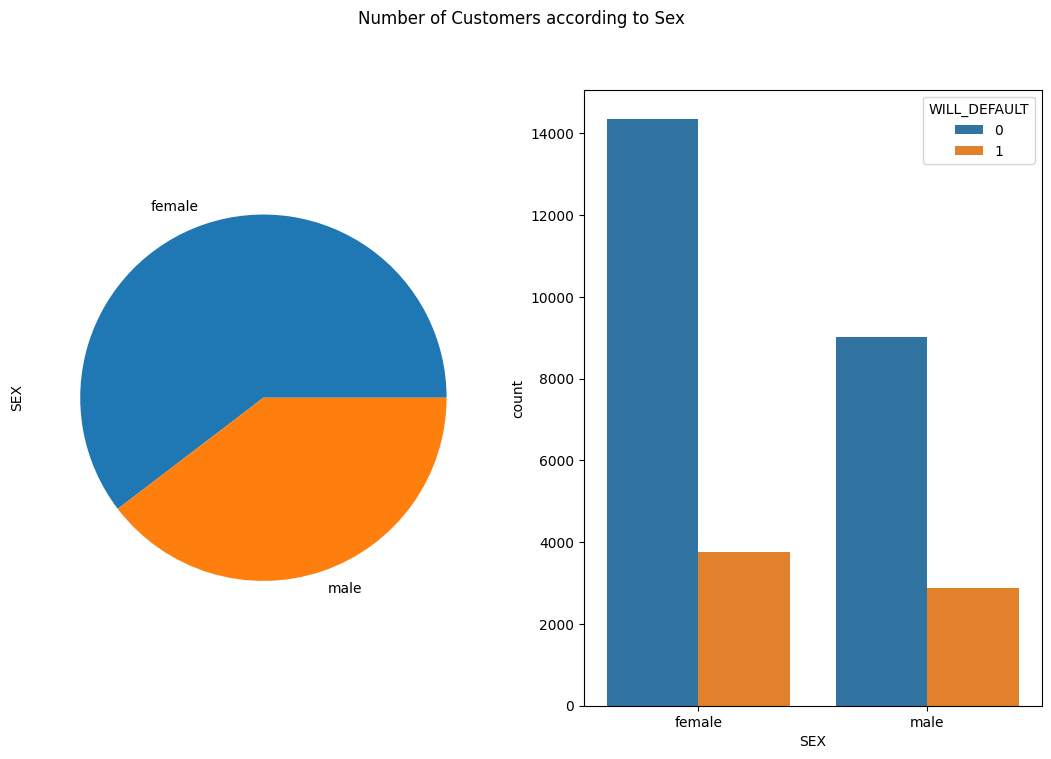

<Figure size 1000x500 with 0 Axes>

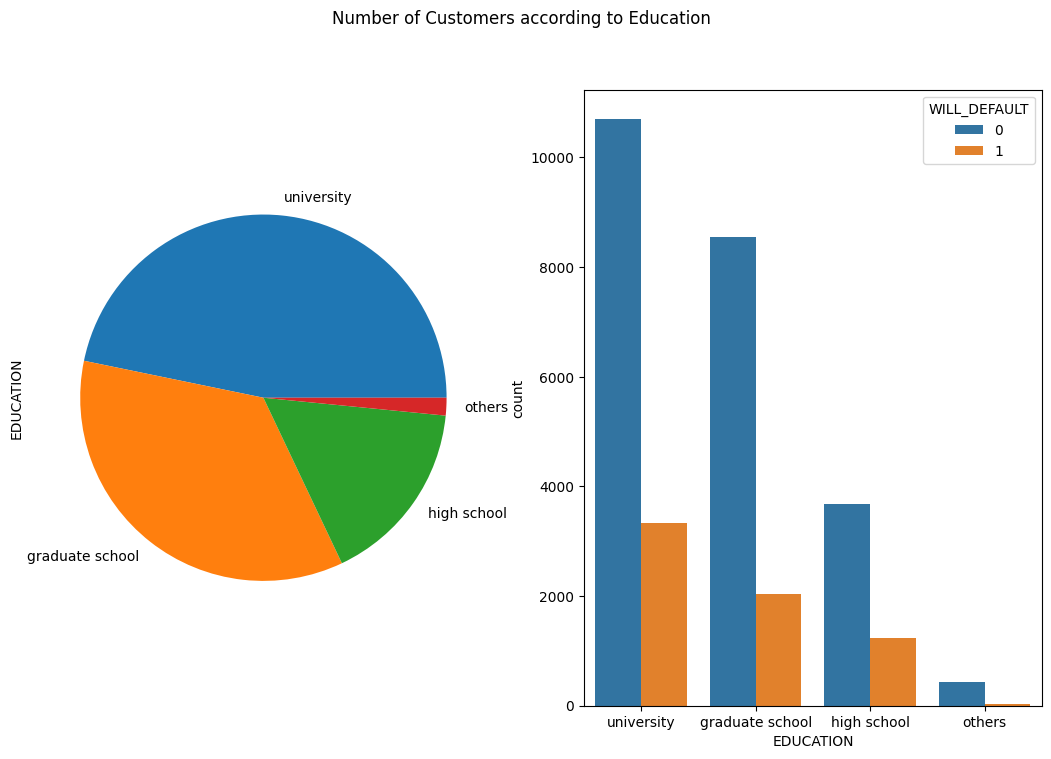

<Figure size 1000x500 with 0 Axes>

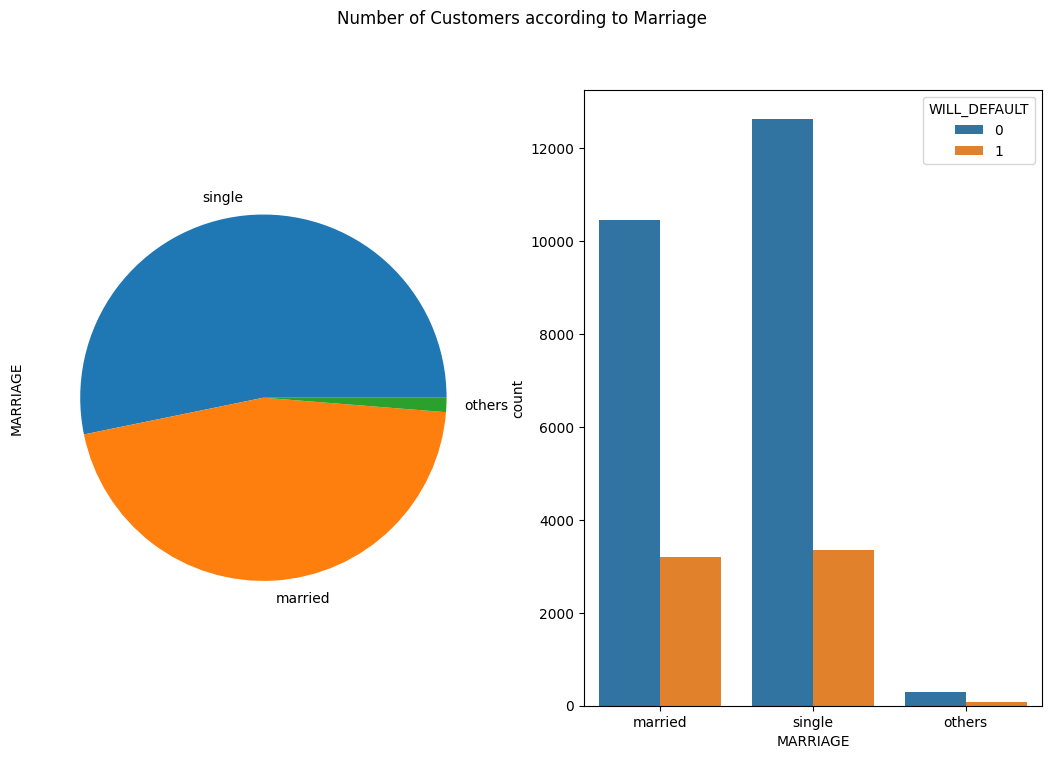

In [36]:
for col in categorical_features:
    plt.figure(figsize=(10,5))
    fig, axes = plt.subplots(ncols=2,figsize=(13,8))
    df_cat[col].value_counts().plot(kind="pie",ax = axes[0],subplots=True, title=f'Number of Customers according to {col.capitalize()}')
    sns.countplot(x = col, hue = 'WILL_DEFAULT', data = df_cat)

##### Numerical Variables

In [48]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

**Limit Balance**

In [49]:
df['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

[Text(0.5, 1.0, 'Average Limit Balance for Default and Non-Default Customers')]

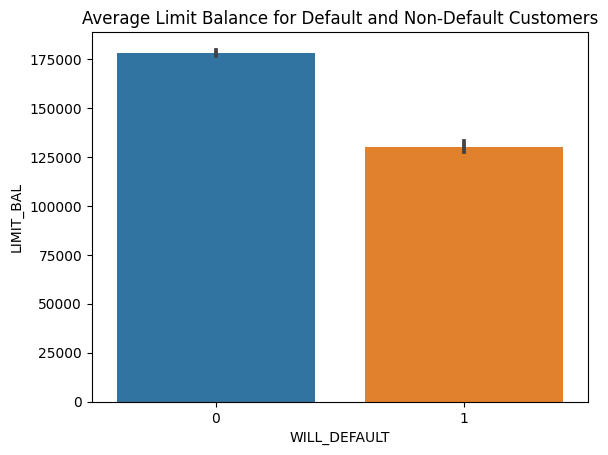

In [50]:
sns.barplot(x='WILL_DEFAULT', y='LIMIT_BAL', data=df).set(title='Average Limit Balance for Default and Non-Default Customers')

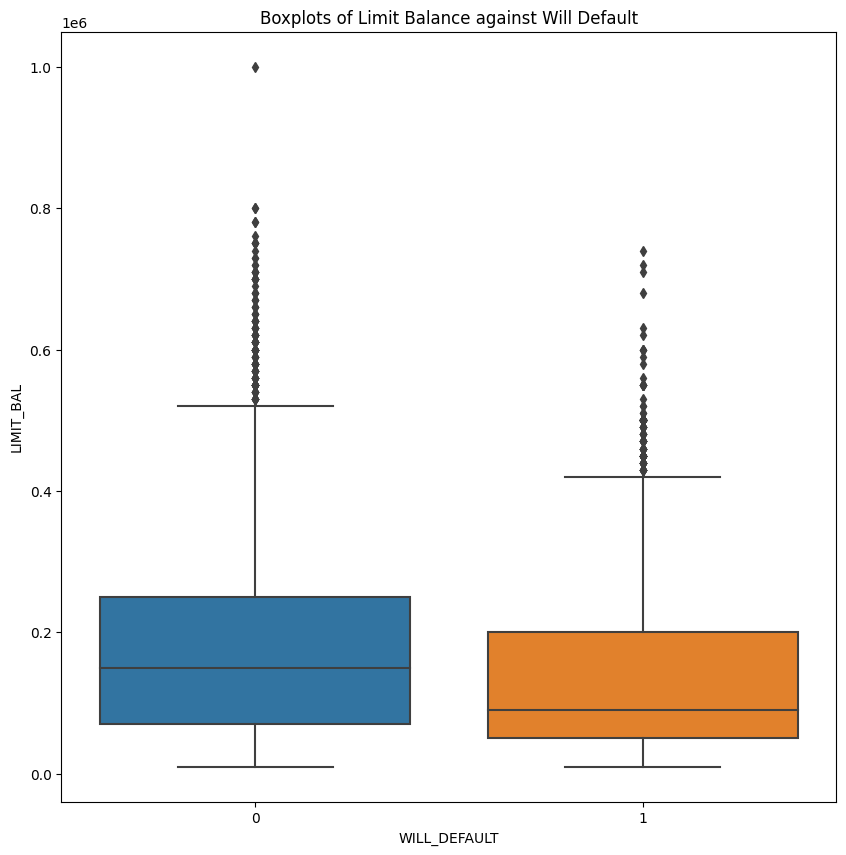

In [51]:
# TODO: Distribution of limit balances for those who default or not
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="WILL_DEFAULT", y="LIMIT_BAL", data=df).set(title='Boxplots of Limit Balance against Will Default')

**Age**

In [52]:
# TODO: Examine age demographics of customers
df['AGE'].value_counts().sort_index()

21      67
22     560
23     931
24    1127
25    1186
26    1256
27    1477
28    1409
29    1605
30    1395
31    1217
32    1158
33    1146
34    1162
35    1113
36    1108
37    1041
38     944
39     954
40     870
41     824
42     794
43     670
44     700
45     617
46     570
47     501
48     466
49     452
50     411
51     340
52     304
53     325
54     247
55     209
56     178
57     122
58     122
59      83
60      67
61      56
62      44
63      31
64      31
65      24
66      25
67      16
68       5
69      15
70      10
71       3
72       3
73       4
74       1
75       3
79       1
Name: AGE, dtype: int64

<AxesSubplot: xlabel='index', ylabel='AGE'>

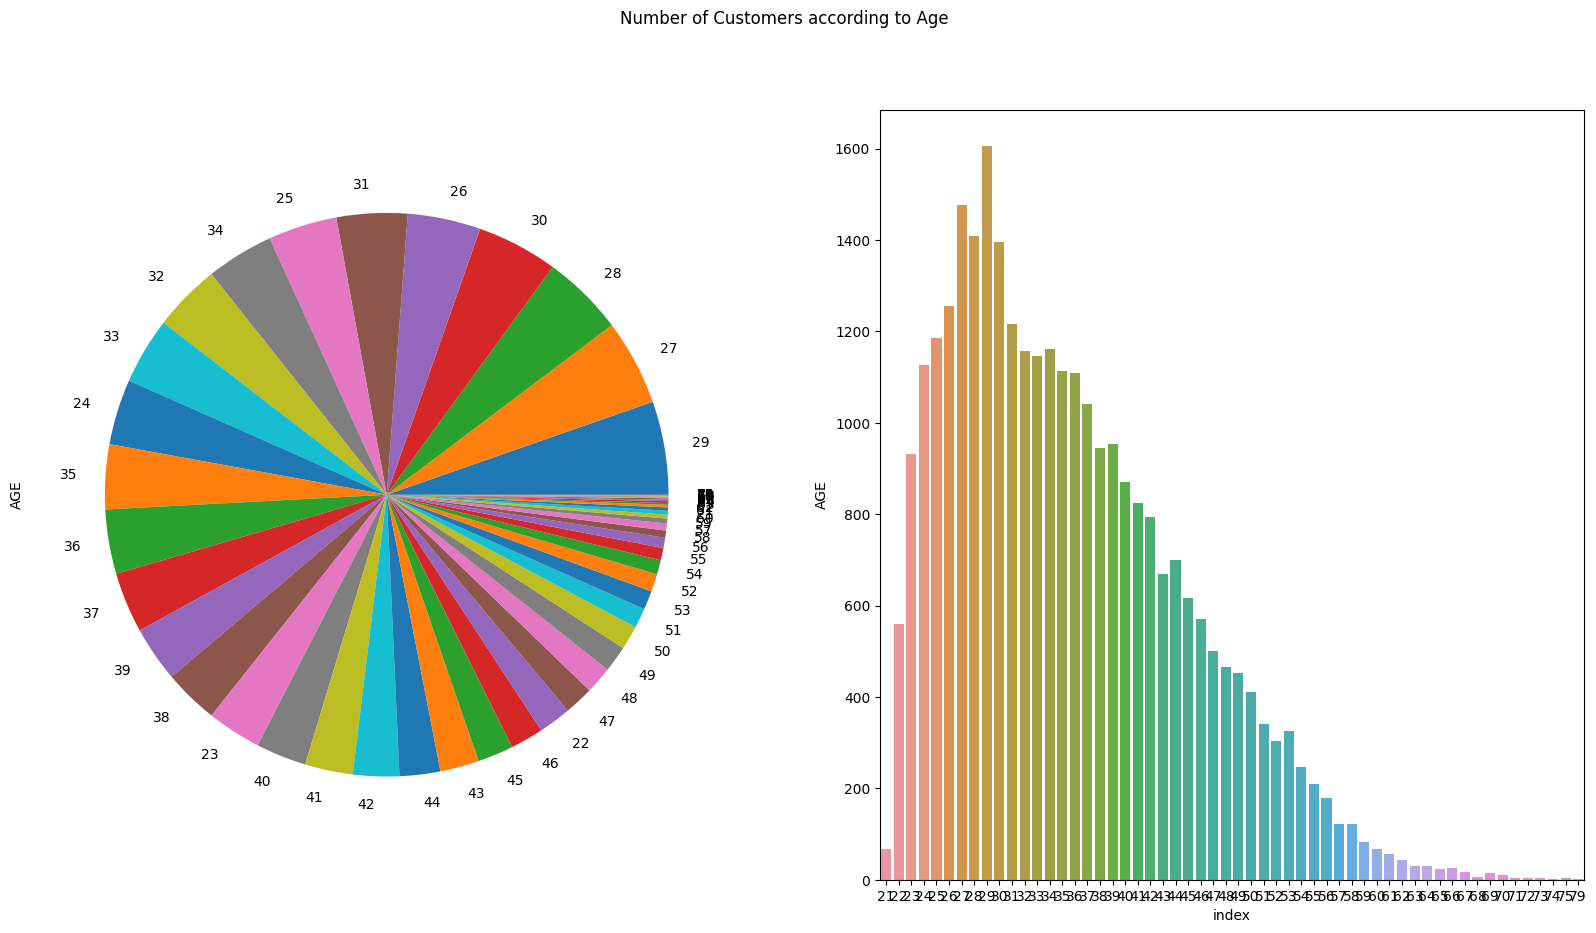

In [53]:
# Examine age demographics of customers
fig, axes = plt.subplots(ncols=2,figsize=(20,10))
Day_df=df['AGE'].value_counts().reset_index()
df['AGE'].value_counts().plot(kind="pie",ax = axes[0],subplots=True, title='Number of Customers according to Age')
sns.barplot(x='index',y='AGE',data=Day_df,ax = axes[1],orient='v')

In [54]:
# Examine distribution of age values
df.groupby('WILL_DEFAULT')['AGE'].describe()

,count,mean,std,min,25%,50%,75%,max
WILL_DEFAULT,,,,,,,,
0,23364.0,35.417266,9.077355,21.0,28.0,34.0,41.0,79.0
1,6636.0,35.725738,9.693438,21.0,28.0,34.0,42.0,75.0


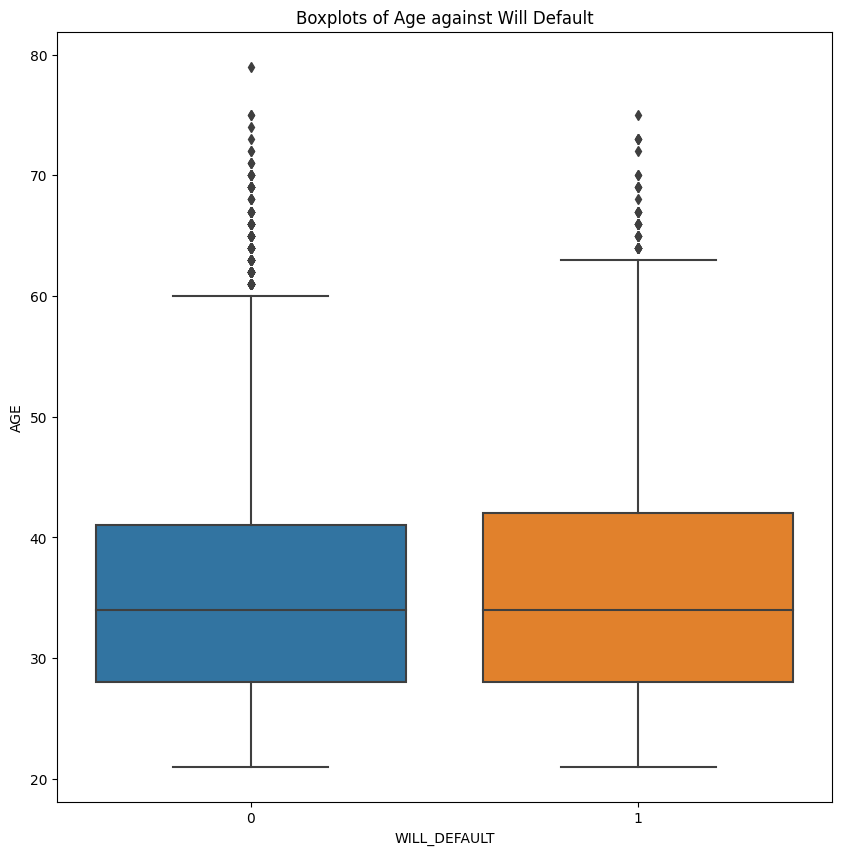

In [55]:
# Examine distribution of age values based on default or not
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="WILL_DEFAULT", y="AGE", data=df).set(title='Boxplots of Age against Will Default')

#### Bill Amount

In [56]:
bill_amnt_df = df[['BILL_AMT_SEPT',	'BILL_AMT_AUG',	'BILL_AMT_JUL',	'BILL_AMT_JUN',	'BILL_AMT_MAY',	'BILL_AMT_APR', 'WILL_DEFAULT']]

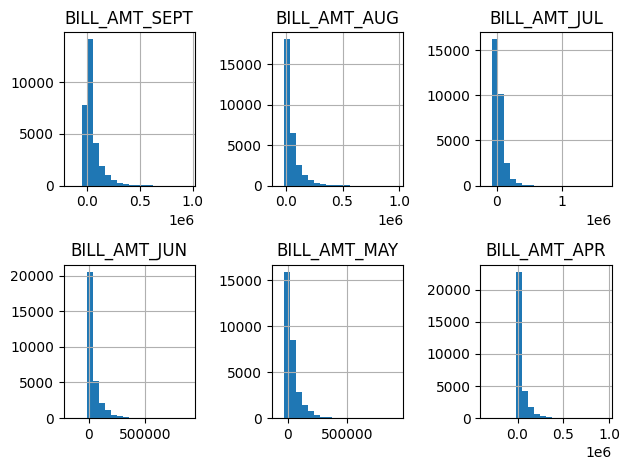

In [57]:
draw_histograms(bill_amnt_df, bill_amnt_df.columns[:-1], 2, 3, 20)

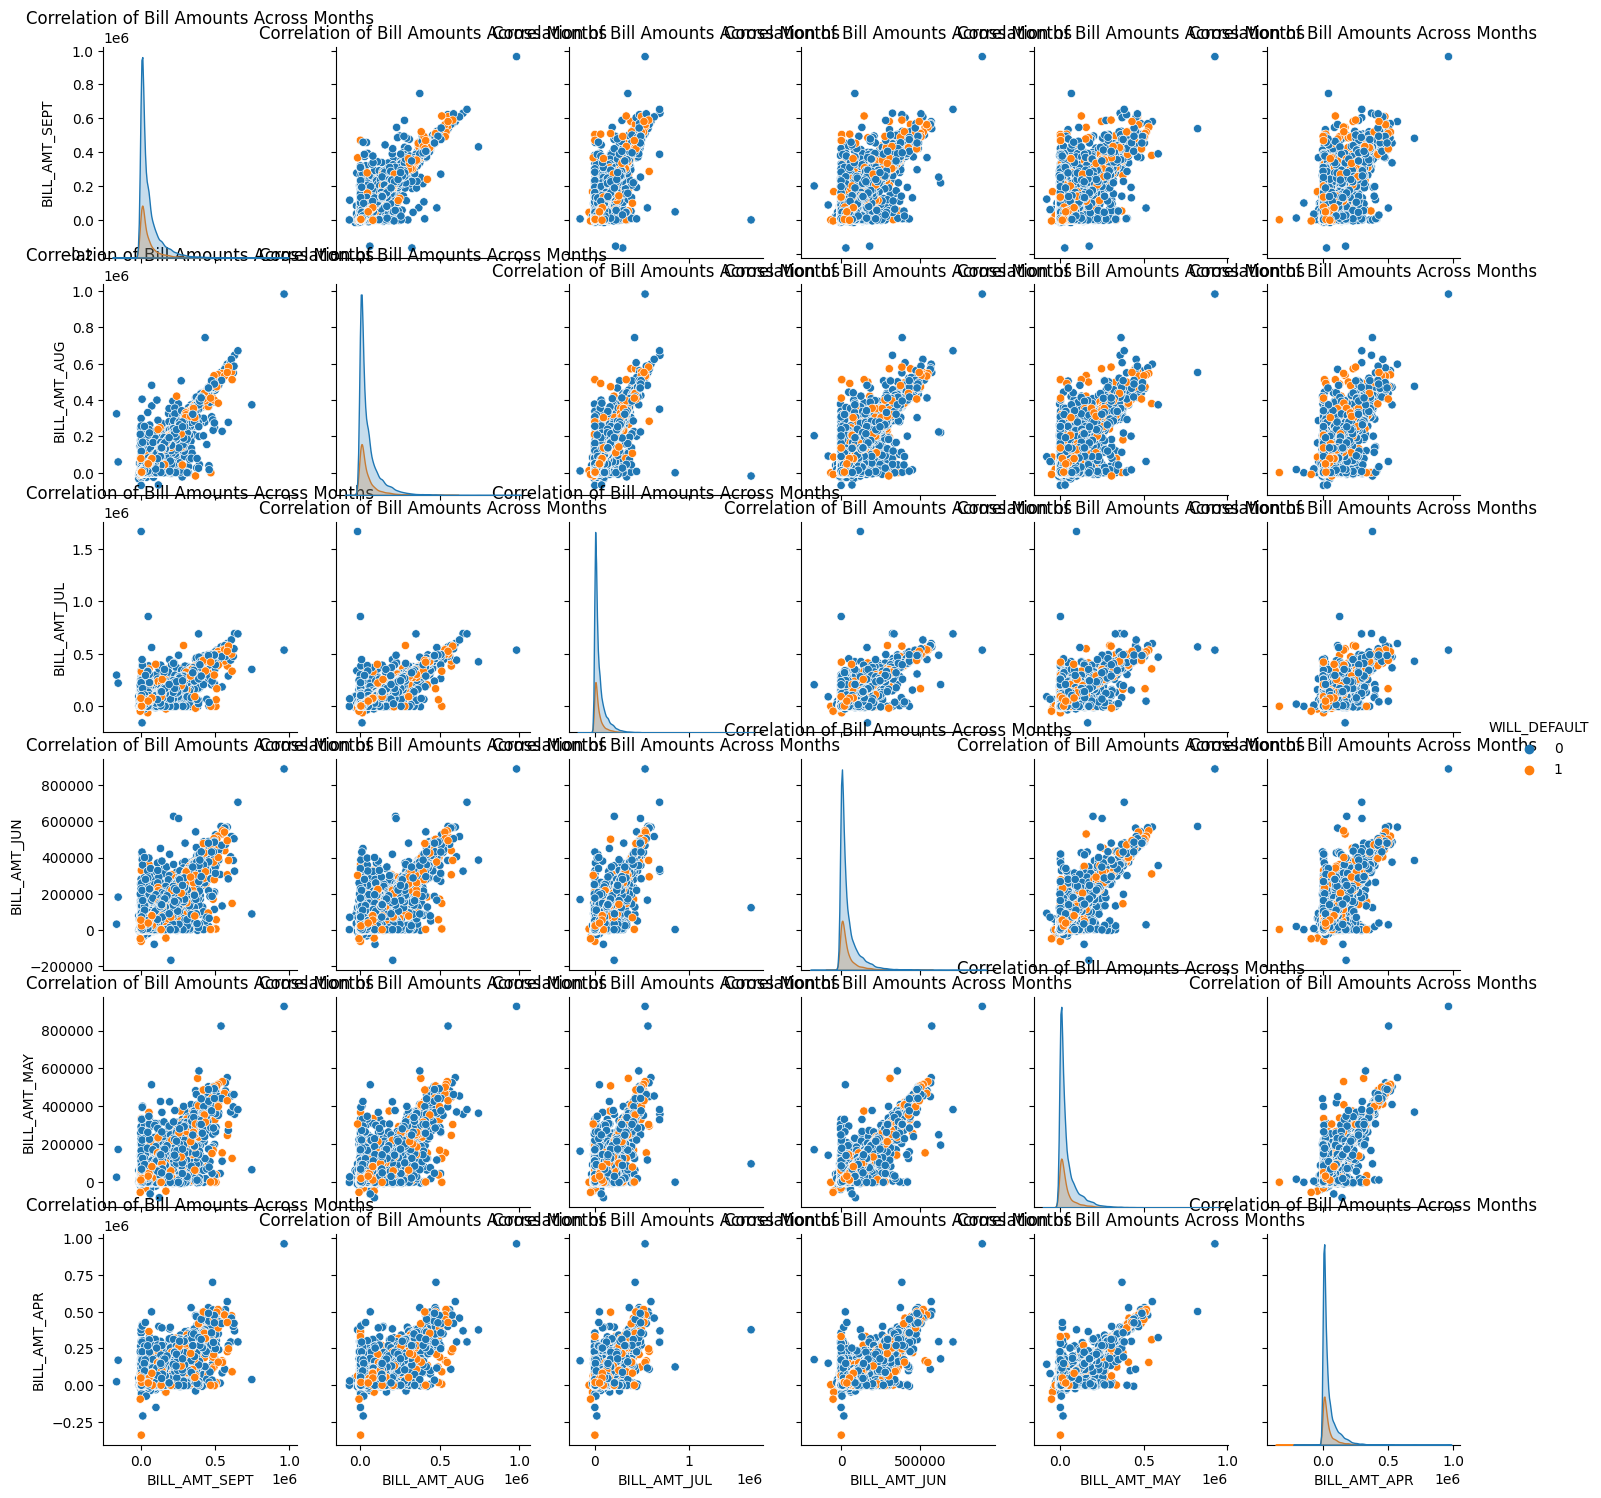

In [58]:
# TODO: Check for correlation of bill amounts across months
sns.pairplot(data = bill_amnt_df, hue='WILL_DEFAULT').set(title='Correlation of Bill Amounts Across Months')

#### Repayment Status

In [60]:
df['PAY_SEPT'].value_counts()


 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_SEPT, dtype: int64

In [67]:
months = ['SEPT', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']

for month in months:
    fil = (df[f'PAY_{month}'] == -1) | (df[f'PAY_{month}'] == -2)
    df.loc[fil, f'PAY_{month}'] = 0
    df[f'PAY_{month}'].value_counts()

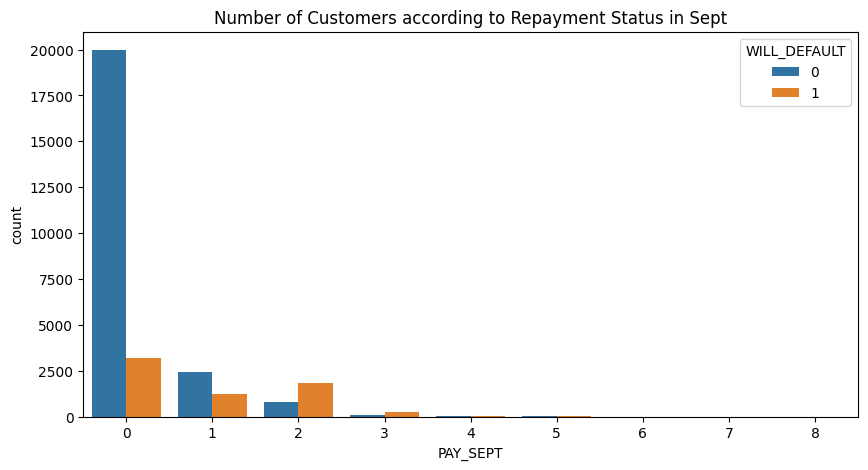

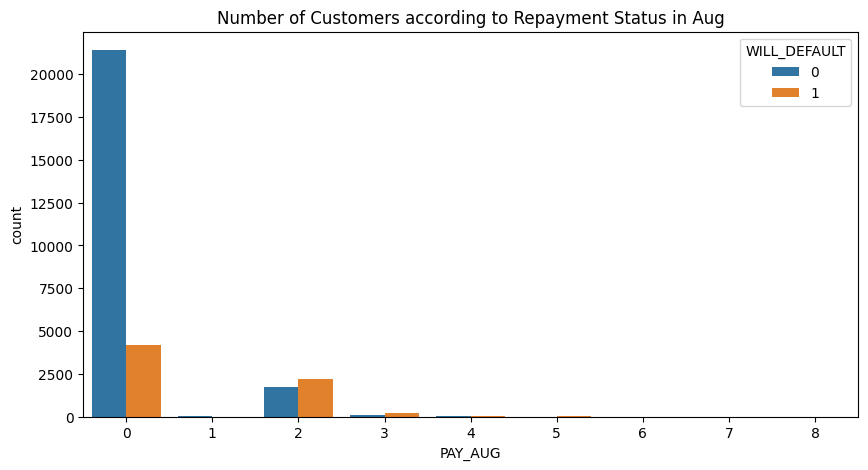

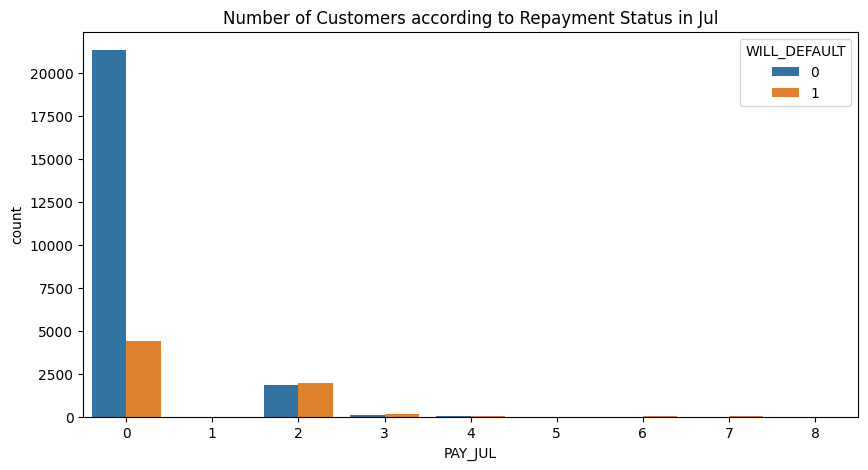

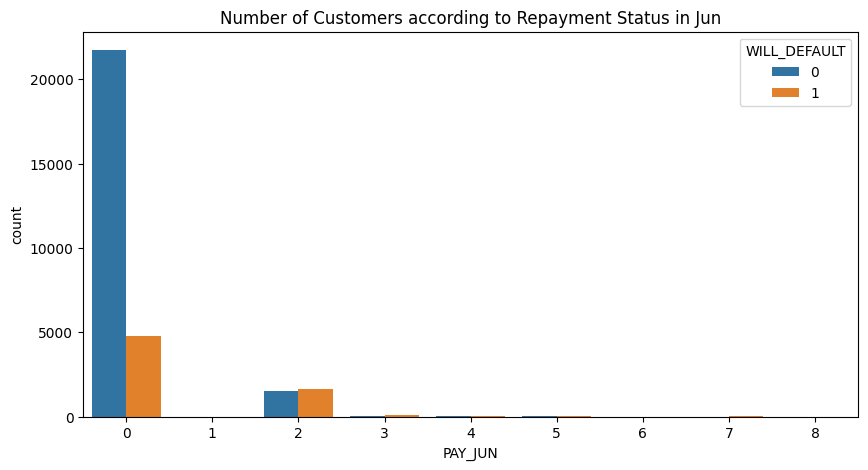

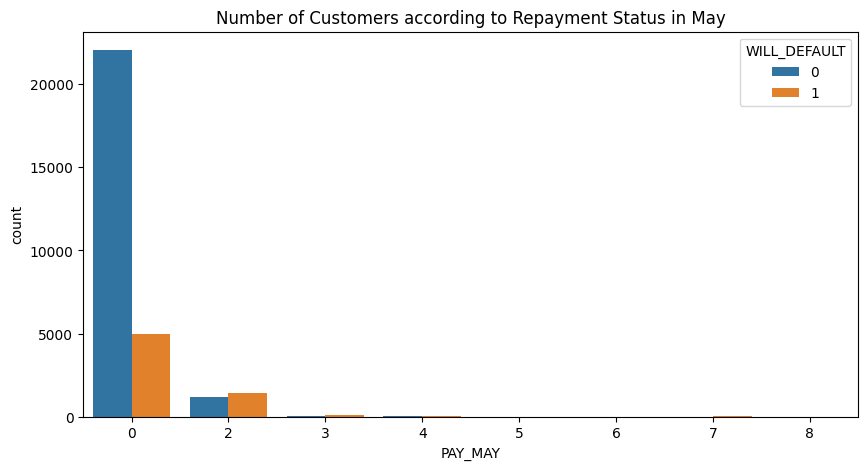

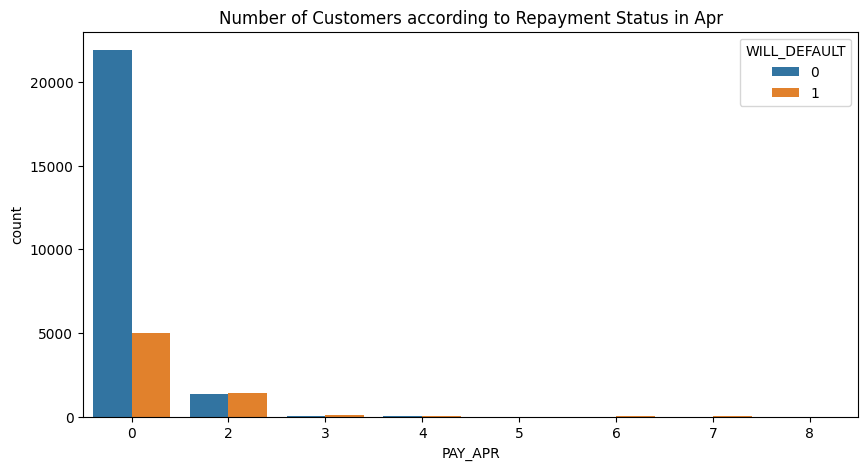

In [70]:
# TODO: Check number of people in each repayment status across months
pay_col = ['PAY_SEPT',	'PAY_AUG',	'PAY_JUL',	'PAY_JUN',	'PAY_MAY',	'PAY_APR']
for col in pay_col:
    month = col[4:].capitalize()
    plt.figure(figsize=(10,5))
    sns.countplot(x = col, hue = 'WILL_DEFAULT', data = df).set(title=f'Number of Customers according to Repayment Status in {month}')

#### Paid Amount

In [71]:
pay_amnt_df = df[['PAY_AMT_SEPT','PAY_AMT_AUG',	'PAY_AMT_JUL',	'PAY_AMT_JUN',	'PAY_AMT_MAY',	'PAY_AMT_APR', 'WILL_DEFAULT']]

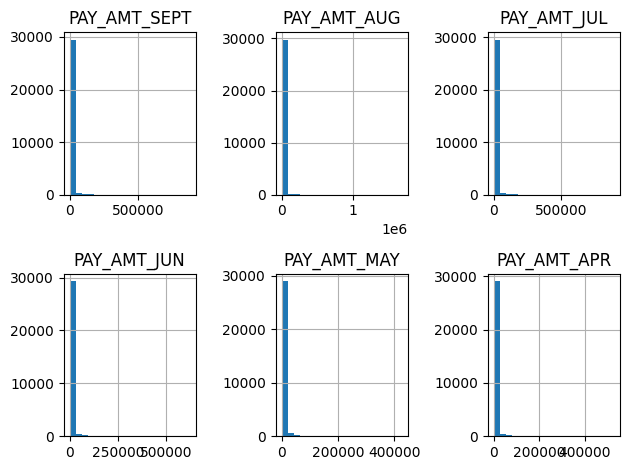

In [72]:
draw_histograms(pay_amnt_df, pay_amnt_df.columns[:-1], 2, 3, 20)

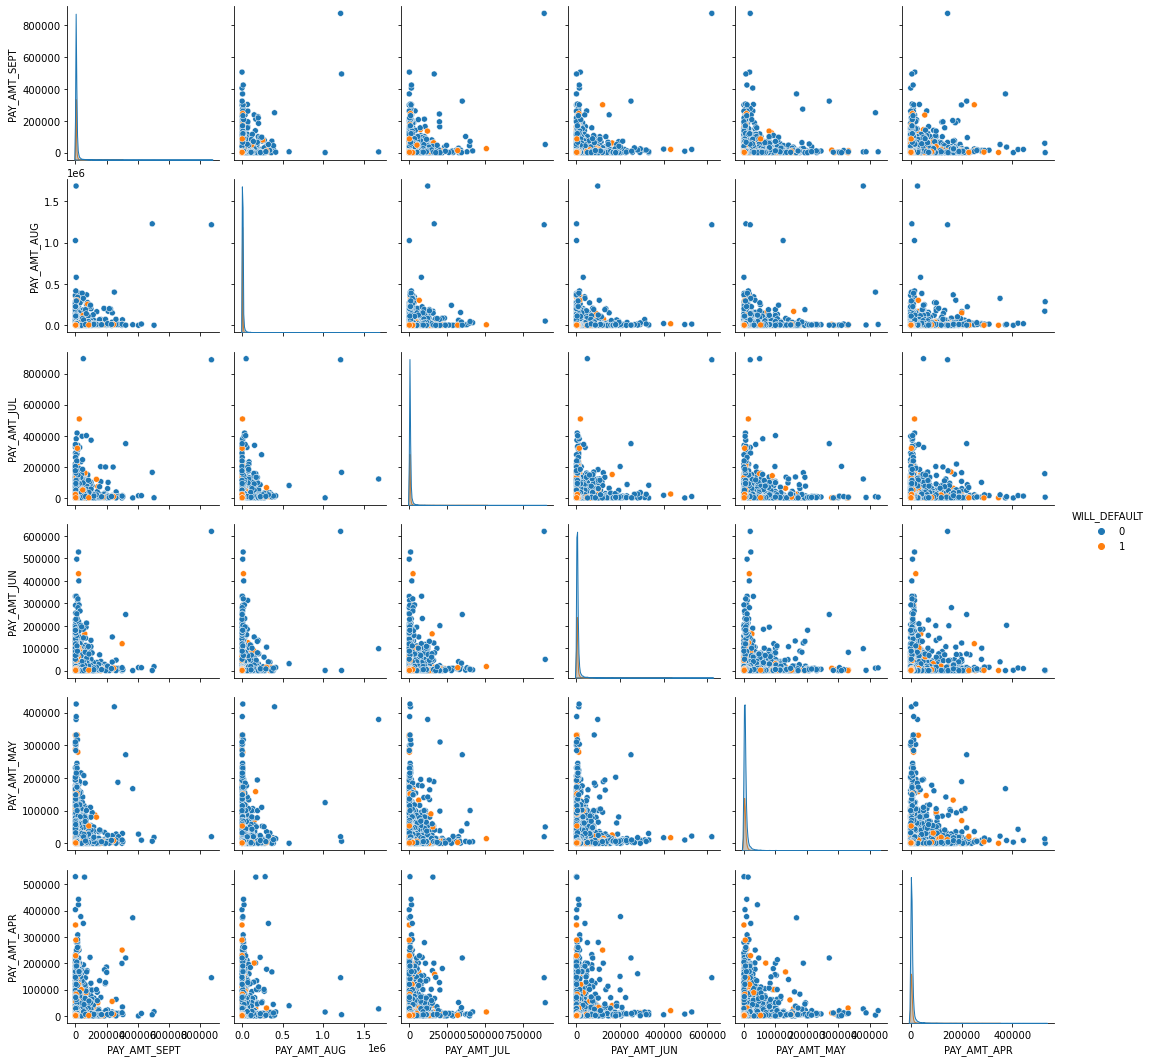

In [48]:
# TODO: Check correlation of bill amounts across months
sns.pairplot(data = pay_amnt_df, hue='WILL_DEFAULT')

#### Dependent Variable

0    23364
1     6636
Name: WILL_DEFAULT, dtype: int64

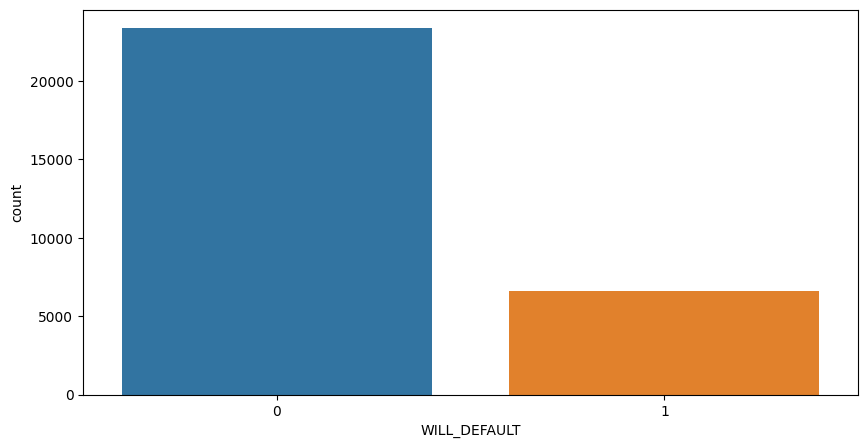

In [73]:
# Check for balanced dataset
plt.figure(figsize=(10,5))
sns.countplot(x = 'WILL_DEFAULT', data = df)
df['WILL_DEFAULT'].value_counts()

In [50]:
# Note that this also means a prediction of zero gives almost 80% accurac y
23364/30000

0.7788

In [123]:
df.to_csv('EDA.csv')

### Data Preprocessing

This involves transforming raw data into an understandable and usable format.

References:
- Lecture 4 notes
- https://towardsdatascience.com/tagged/data-pre-processing
- https://towardsdatascience.com/data-pre-processing-techniques-you-should-know-8954662716d6

In [452]:
eda_df_model = evaluate_data_using_tree('EDA.csv', verbose=2)


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.820178  0.816933

Displaying evaluation metrics on model...

      Metric      Test
0   Accuracy  0.816933
1  Precision  0.336950
2     Recall  0.671875
3         f1  0.448816
4  ROC Score  0.753454


In [143]:
df_dp = pd.read_csv('EDA.csv')
df_dp.drop(["Unnamed: 0"], axis=1, inplace=True)

##### Initial Preprocessing


1. Check for redundant features (low-variance or highly correlated) and samples
2. Check for outliers
3. Check for missing values

In [145]:
#TODO: Check for duplicate rows

# Calculate duplicates
dups = df_dp.duplicated()
# report if there are any duplicates
print(dups.any())

False


(30000, 24) (30000,)
>Threshold=0.00, Features=24
>Threshold=0.05, Features=24
>Threshold=0.10, Features=24
>Threshold=0.15, Features=24
>Threshold=0.20, Features=24
>Threshold=0.25, Features=23
>Threshold=0.30, Features=22
>Threshold=0.35, Features=22
>Threshold=0.40, Features=22
>Threshold=0.45, Features=22
>Threshold=0.50, Features=22
>Threshold=0.55, Features=20
>Threshold=0.60, Features=17
>Threshold=0.65, Features=15
>Threshold=0.70, Features=15


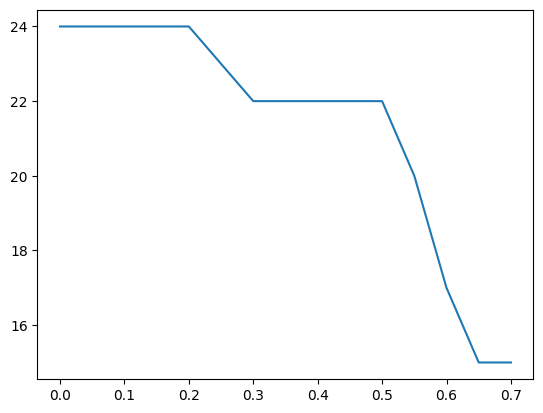

In [146]:
#TODO: Sparse column identification and removal - only makes sense for numerical features

# split data into inputs and outputs
data = df_dp.values
X = data[:, :-1]
y = data[:, -1]
print(X.shape, y.shape)
# define thresholds to check
thresholds = arange(0.0, 0.75, 0.05)
# apply transform with each threshold
results = list()
for t in thresholds:
	# define the transform
	transform = VarianceThreshold(threshold=t)
	# transform the input data
	X_sel = transform.fit_transform(X)
	# determine the number of input features
	n_features = X_sel.shape[1]
	print('>Threshold=%.2f, Features=%d' % (t, n_features))
	# store the result
	results.append(n_features)
# plot the threshold vs the number of selected features
pyplot.plot(thresholds, results)
pyplot.show()

In [147]:
# TODO: Add outliers checking through sampling
# Sample data that are considered as outliers in the above 3 approaches

#### Sample

In [148]:
# People who paid a lot of money in the previous month
# Find out why
df[df.PAY_AMT_SEPT > 300000][['LIMIT_BAL', 'PAY_SEPT',  'PAY_AMT_SEPT','BILL_AMT_SEPT', 'PAY_AUG',
                          'PAY_AMT_AUG', 'BILL_AMT_AUG', 'WILL_DEFAULT']]
# Sensible data, very rich people -> not outliers

,LIMIT_BAL,PAY_SEPT,PAY_AMT_SEPT,BILL_AMT_SEPT,PAY_AUG,PAY_AMT_AUG,BILL_AMT_AUG,WILL_DEFAULT
2687,500000,0,368199,71921,0,6486,367979,0
5687,480000,0,302000,106660,0,66270,400000,0
8500,400000,0,405016,6500,0,0,405016,0
12330,300000,1,505000,-165580,0,331,324392,0
25431,170000,0,304815,30860,0,8000,167941,0
28003,510000,0,493358,71121,0,1227082,481382,0
28716,340000,0,873552,139808,0,1215471,176743,0
29820,400000,1,423903,396343,0,15100,394858,0
29867,340000,0,300039,44855,0,13214,331641,0
29963,610000,0,323014,348392,0,1605,322228,0


In [149]:
# Understanding trend of default
df[['PAY_AMT_SEPT', 'BILL_AMT_SEPT', 'PAY_AMT_AUG', 
     'BILL_AMT_AUG', 'PAY_AMT_JUL', 'BILL_AMT_JUL', 'PAY_AMT_JUN', 'BILL_AMT_JUN', 
     'PAY_AMT_MAY', 'BILL_AMT_MAY',
     'PAY_AMT_APR', 'BILL_AMT_APR',
     'LIMIT_BAL', 'WILL_DEFAULT']].sample(30).sort_values('WILL_DEFAULT')

# Seems like if bill amount has an increasing trend, likelihood of default is high

,PAY_AMT_SEPT,BILL_AMT_SEPT,PAY_AMT_AUG,BILL_AMT_AUG,PAY_AMT_JUL,BILL_AMT_JUL,PAY_AMT_JUN,BILL_AMT_JUN,PAY_AMT_MAY,BILL_AMT_MAY,PAY_AMT_APR,BILL_AMT_APR,LIMIT_BAL,WILL_DEFAULT
6093,0,3302,679,0,0,679,5000,679,2000,5679,0,7570,20000,0
21990,2100,50029,2000,48347,2100,49268,1400,50437,1600,37302,1600,38302,50000,0
22298,390,790,99235,390,4368,99235,3449,98080,3713,97224,3610,97940,130000,0
6125,10523,6911,4790,10507,4736,4785,55762,4567,4209,11762,22815,4209,30000,0
27249,676,0,0,676,10500,-104,337,9732,333,9927,407,9339,50000,0
27596,1088,2783,2855,1080,20787,2855,8314,20787,1747,8307,309,1747,210000,0
11845,0,190,3054,-310,2189,1527,0,1901,2706,0,0,2706,210000,0
8253,8932,237868,4707,242260,1862,101542,140061,30284,5262,168674,5300,171825,240000,0
22624,3379,84298,3469,85379,4380,87469,3355,90380,3565,91355,3607,92565,210000,0
26614,0,18781,0,13255,20358,0,0,20358,2577,18044,0,20325,20000,0


In [150]:
df[df.WILL_DEFAULT == 1][['BILL_AMT_AUG',
     'PAY_AMT_SEPT', 'BILL_AMT_SEPT', 'PAY_SEPT',
     'LIMIT_BAL']].sample(30)

,BILL_AMT_AUG,PAY_AMT_SEPT,BILL_AMT_SEPT,PAY_SEPT,LIMIT_BAL
4006,1050,0,1050,2,10000
11206,2443,0,2443,2,200000
18291,390,0,780,0,80000
23253,671,671,671,0,180000
26813,116437,6013,122486,0,130000
6292,14722,1243,17243,0,470000
11745,54223,54300,2610,0,110000
22537,48332,2200,47406,0,50000
8574,0,0,0,1,150000
12761,37891,1150,50000,0,50000


In [151]:
fil = ((df.PAY_APR == 0) & (df.BILL_AMT_MAY > 0) & (df.PAY_MAY > 0))
df[fil][['BILL_AMT_APR', 'PAY_AMT_MAY', 'BILL_AMT_MAY', 'PAY_MAY']].sample(20)

,BILL_AMT_APR,PAY_AMT_MAY,BILL_AMT_MAY,PAY_MAY
12024,47519,2200,46284,2
14121,191626,10000,195475,2
16136,172042,7250,167294,2
499,19933,800,20255,2
18284,8134,299,7963,2
4957,31601,3000,29099,2
9023,30000,1000,29933,2
21532,7990,500,7614,2
19375,66643,2375,75536,2
15383,25871,3000,23253,2


In [152]:
fil = ((df.PAY_AMT_SEPT > df.BILL_AMT_AUG) & (df.PAY_AUG == 0))
df[fil][['PAY_AMT_AUG', 'BILL_AMT_AUG', 'PAY_AUG', 'PAY_AMT_SEPT', 'BILL_AMT_SEPT', 'PAY_SEPT', 'LIMIT_BAL', 'WILL_DEFAULT']].sample(15)


,PAY_AMT_AUG,BILL_AMT_AUG,PAY_AUG,PAY_AMT_SEPT,BILL_AMT_SEPT,PAY_SEPT,LIMIT_BAL,WILL_DEFAULT
23214,3702,20927,0,20965,5119,0,210000,0
24606,9569,5795,0,5807,7488,0,290000,0
8625,156292,10053,0,10096,27414,0,150000,0
3999,4380,8054,0,8077,2429,0,170000,1
16903,4028,71944,0,72024,10380,0,100000,0
735,18862,-1041,0,1041,27345,0,70000,0
6538,0,375,0,1000,875,0,230000,0
25799,54478,3751,0,6425,-1244,0,300000,0
27905,3475,3036,0,3084,3655,0,200000,0
16882,2184,2659,0,2669,6682,0,150000,0


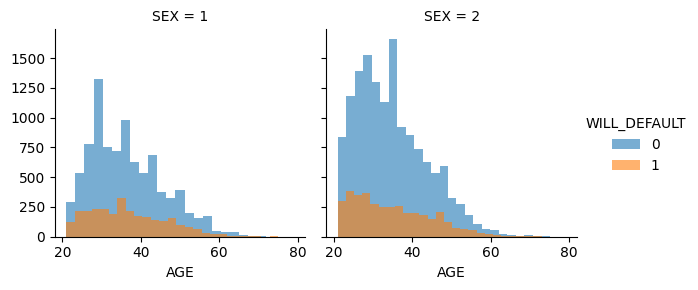

In [153]:
g = sns.FacetGrid(df, col='SEX', hue='WILL_DEFAULT')
g.map(plt.hist, 'AGE', alpha=0.6, bins=25) #alpha is for opacity
g.add_legend()

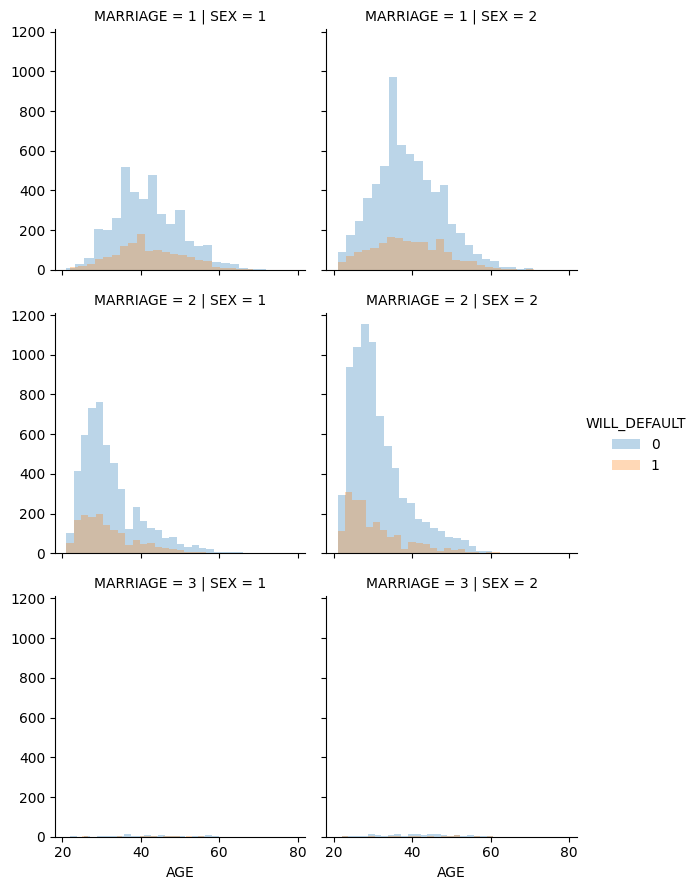

In [154]:
g = sns.FacetGrid(df, col='SEX', row= "MARRIAGE", hue='WILL_DEFAULT')
g.map(plt.hist, 'AGE', alpha=0.3, bins=25) 
g.add_legend()

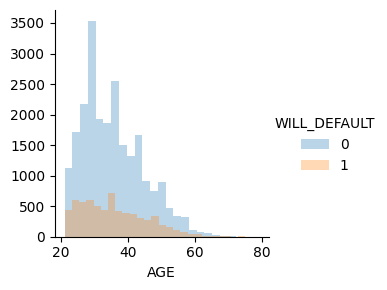

In [155]:
g = sns.FacetGrid(df, hue='WILL_DEFAULT')
g.map(plt.hist, 'AGE', alpha=0.3, bins=25) 
g.add_legend()

Feature Enginering
1. A variable to capture trend of bill amount
2. Duration of trend
3. Late or not
4. Combining sex and marriage
5. Creating age groups
6. Average monthly expenses
7. Size of bill relative to limit balance

In [156]:
# TODO: Remove missing values
df_dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ID             30000 non-null  int64
 1   LIMIT_BAL      30000 non-null  int64
 2   SEX            30000 non-null  int64
 3   EDUCATION      30000 non-null  int64
 4   MARRIAGE       30000 non-null  int64
 5   AGE            30000 non-null  int64
 6   PAY_SEPT       30000 non-null  int64
 7   PAY_AUG        30000 non-null  int64
 8   PAY_JUL        30000 non-null  int64
 9   PAY_JUN        30000 non-null  int64
 10  PAY_MAY        30000 non-null  int64
 11  PAY_APR        30000 non-null  int64
 12  BILL_AMT_SEPT  30000 non-null  int64
 13  BILL_AMT_AUG   30000 non-null  int64
 14  BILL_AMT_JUL   30000 non-null  int64
 15  BILL_AMT_JUN   30000 non-null  int64
 16  BILL_AMT_MAY   30000 non-null  int64
 17  BILL_AMT_APR   30000 non-null  int64
 18  PAY_AMT_SEPT   30000 non-null  int64
 19  PAY_

In [157]:
df_dp.to_csv('DP.csv')

In [453]:
dp_df_model = evaluate_data_using_tree('DP.csv', verbose=2)


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.820178  0.816933

Displaying evaluation metrics on model...

      Metric      Test
0   Accuracy  0.816933
1  Precision  0.336950
2     Recall  0.671875
3         f1  0.448816
4  ROC Score  0.753454


##### Feature Transformation

In [160]:
df_ft = pd.read_csv('DP.csv')
df_ft.drop(["Unnamed: 0"], axis=1, inplace=True)
df_ft.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,WILL_DEFAULT
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [161]:
df_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ID             30000 non-null  int64
 1   LIMIT_BAL      30000 non-null  int64
 2   SEX            30000 non-null  int64
 3   EDUCATION      30000 non-null  int64
 4   MARRIAGE       30000 non-null  int64
 5   AGE            30000 non-null  int64
 6   PAY_SEPT       30000 non-null  int64
 7   PAY_AUG        30000 non-null  int64
 8   PAY_JUL        30000 non-null  int64
 9   PAY_JUN        30000 non-null  int64
 10  PAY_MAY        30000 non-null  int64
 11  PAY_APR        30000 non-null  int64
 12  BILL_AMT_SEPT  30000 non-null  int64
 13  BILL_AMT_AUG   30000 non-null  int64
 14  BILL_AMT_JUL   30000 non-null  int64
 15  BILL_AMT_JUN   30000 non-null  int64
 16  BILL_AMT_MAY   30000 non-null  int64
 17  BILL_AMT_APR   30000 non-null  int64
 18  PAY_AMT_SEPT   30000 non-null  int64
 19  PAY_

In [162]:
df_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ID             30000 non-null  int64
 1   LIMIT_BAL      30000 non-null  int64
 2   SEX            30000 non-null  int64
 3   EDUCATION      30000 non-null  int64
 4   MARRIAGE       30000 non-null  int64
 5   AGE            30000 non-null  int64
 6   PAY_SEPT       30000 non-null  int64
 7   PAY_AUG        30000 non-null  int64
 8   PAY_JUL        30000 non-null  int64
 9   PAY_JUN        30000 non-null  int64
 10  PAY_MAY        30000 non-null  int64
 11  PAY_APR        30000 non-null  int64
 12  BILL_AMT_SEPT  30000 non-null  int64
 13  BILL_AMT_AUG   30000 non-null  int64
 14  BILL_AMT_JUL   30000 non-null  int64
 15  BILL_AMT_JUN   30000 non-null  int64
 16  BILL_AMT_MAY   30000 non-null  int64
 17  BILL_AMT_APR   30000 non-null  int64
 18  PAY_AMT_SEPT   30000 non-null  int64
 19  PAY_

In [163]:
df_ft.to_csv('FT.csv')

In [454]:
ft_df_model = evaluate_data_using_tree('FT.csv', verbose=2)


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.820178  0.816933

Displaying evaluation metrics on model...

      Metric      Test
0   Accuracy  0.816933
1  Precision  0.336950
2     Recall  0.671875
3         f1  0.448816
4  ROC Score  0.753454


##### Feature Engineering

In [25]:
df_fe = pd.read_csv('FT.csv')
df_fe.drop(['Unnamed: 0'], axis=1, inplace=True)
df_fe.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,WILL_DEFAULT
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Feature Enginering
1. A variable to capture trend of bill amount
2. Duration of trend
3. Late or not
4. Combining sex and marriage
5. Creating age groups
6. Average monthly expenses
7. Size of bill relative to limit balance

In [26]:
# 4 Combining sex and marriage
df_fe['SEX_MARRIAGE'] = 0
df_fe.loc[((df.SEX == 1) & (df.MARRIAGE == 1)) , 'SEX_MARRIAGE'] = 1 #married man
df_fe.loc[((df.SEX == 1) & (df.MARRIAGE == 2)) , 'SEX_MARRIAGE'] = 2 #single man
df_fe.loc[((df.SEX == 2) & (df.MARRIAGE == 1)) , 'SEX_MARRIAGE'] = 3 #married woman
df_fe.loc[((df.SEX == 2) & (df.MARRIAGE == 2)) , 'SEX_MARRIAGE'] = 4 #single woman
df_fe.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,WILL_DEFAULT,SEX_MARRIAGE
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,689,0,0,0,0,1,3
1,2,120000,2,2,2,26,0,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,4
2,3,90000,2,2,2,34,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,4
3,4,50000,2,2,1,37,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,3
4,5,50000,1,2,1,57,0,0,0,0,...,19146,19131,2000,36681,10000,9000,689,679,0,1


In [27]:
sex_marriage = get_percentage_relation(df_fe, 'SEX_MARRIAGE', 'WILL_DEFAULT')
sex_marriage.rename(index={0: 'Others', 1: 'Married Man', 2: 'Single Man',
                          3: 'Married Woman', 4: 'Single Woman'}, inplace=True)
sex_marriage

# Seems like there's no influence over percentage

WILL_DEFAULT,0,1,Percentage
SEX_MARRIAGE,,,
Others,288,89,0.236074
Married Man,3844,1346,0.259345
Single Man,5068,1485,0.226614
Married Woman,6609,1860,0.219625
Single Woman,7555,1856,0.197216


In [28]:
df_fe['AGE_GROUP'] = pd.qcut(df['AGE'], 6)
df_fe.AGE_GROUP.value_counts()

(26.0, 30.0]      5886
(34.0, 39.0]      5160
(20.999, 26.0]    5127
(30.0, 34.0]      4683
(45.0, 79.0]      4669
(39.0, 45.0]      4475
Name: AGE_GROUP, dtype: int64

<AxesSubplot: >

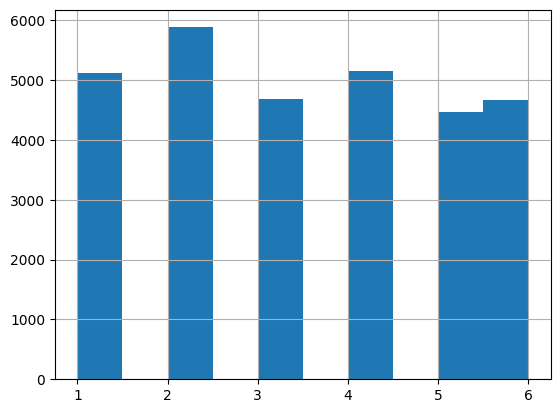

In [29]:
# 5 Creating age groups
bins_names = [1, 2, 3, 4, 5, 6]

# quantile based cut
df_fe['AGE_GROUP'] = pd.qcut(df['AGE'], 6, labels=bins_names)
df_fe.AGE_GROUP.hist()

In [30]:
df_fe.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,WILL_DEFAULT,SEX_MARRIAGE,AGE_GROUP
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,689,0,0,0,0,1,3,1
1,2,120000,2,2,2,26,0,2,0,0,...,3261,0,1000,1000,1000,0,2000,1,4,1
2,3,90000,2,2,2,34,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,4,3
3,4,50000,2,2,1,37,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,3,4
4,5,50000,1,2,1,57,0,0,0,0,...,19131,2000,36681,10000,9000,689,679,0,1,6


In [31]:
age_group = get_percentage_relation(df_fe, 'AGE_GROUP', 'WILL_DEFAULT')
age_group.rename(index={
    3: '(20.999, 26.0]',
    1: '(26.0, 30.0]',
    4: '(30.0, 34.0]',
    2: '(34.0, 39.0]',
    6: '(39.0, 45.0]',
    5: '(45.0, 79.0]'}, inplace=True)

sorted_age_group = age_group.reindex([
    '(20.999, 26.0]', '(26.0, 30.0]', '(30.0, 34.0]', '(34.0, 39.0]', '(39.0, 45.0]', '(45.0, 79.0]'
], copy=True)
sorted_age_group

WILL_DEFAULT,0,1,Percentage
AGE_GROUP,,,
"(20.999, 26.0]",3783,900,0.192184
"(26.0, 30.0]",3842,1285,0.250634
"(30.0, 34.0]",4058,1102,0.213566
"(34.0, 39.0]",4700,1186,0.201495
"(39.0, 45.0]",3491,1178,0.252302
"(45.0, 79.0]",3490,985,0.220112


In [32]:
# 6 Monthly expenses as a percentage of limit balance

df_fe['AVG_EXP_AUG'] = (
    (df_fe['BILL_AMT_AUG'] - (df_fe['BILL_AMT_SEPT'] - df_fe['PAY_AMT_AUG']))
) / df_fe['LIMIT_BAL']

df_fe['AVG_EXP_JUL'] = ((
    (df_fe['BILL_AMT_AUG'] - (df_fe['BILL_AMT_SEPT'] - df_fe['PAY_AMT_AUG'])) +
    (df_fe['BILL_AMT_JUL'] - (df_fe['BILL_AMT_AUG'] - df_fe['PAY_AMT_JUL']))
) / 2) / df_fe['LIMIT_BAL']

df_fe['AVG_EXP_JUN'] = ((
    (df_fe['BILL_AMT_AUG'] - (df_fe['BILL_AMT_SEPT'] - df_fe['PAY_AMT_AUG'])) +
    (df_fe['BILL_AMT_JUL'] - (df_fe['BILL_AMT_AUG'] - df_fe['PAY_AMT_JUL'])) +
    (df_fe['BILL_AMT_JUN'] - (df_fe['BILL_AMT_JUL'] - df_fe['PAY_AMT_JUN']))
) / 3) / df_fe['LIMIT_BAL']

df_fe['AVG_EXP_MAY'] = ((
    (df_fe['BILL_AMT_AUG'] - (df_fe['BILL_AMT_SEPT'] - df_fe['PAY_AMT_AUG'])) +
    (df_fe['BILL_AMT_JUL'] - (df_fe['BILL_AMT_AUG'] - df_fe['PAY_AMT_JUL'])) +
    (df_fe['BILL_AMT_JUN'] - (df_fe['BILL_AMT_JUL'] - df_fe['PAY_AMT_JUN'])) +
    (df_fe['BILL_AMT_MAY'] - (df_fe['BILL_AMT_JUN'] - df_fe['PAY_AMT_MAY']))
) / 4) / df_fe['LIMIT_BAL']

df_fe['AVG_EXP_APR'] = ((
    (df_fe['BILL_AMT_AUG'] - (df_fe['BILL_AMT_SEPT'] - df_fe['PAY_AMT_AUG'])) +
    (df_fe['BILL_AMT_JUL'] - (df_fe['BILL_AMT_AUG'] - df_fe['PAY_AMT_JUL'])) +
    (df_fe['BILL_AMT_JUN'] - (df_fe['BILL_AMT_JUL'] - df_fe['PAY_AMT_JUN'])) +
    (df_fe['BILL_AMT_MAY'] - (df_fe['BILL_AMT_JUN'] - df_fe['PAY_AMT_MAY'])) +
    (df_fe['BILL_AMT_APR'] - (df_fe['BILL_AMT_MAY'] - df_fe['PAY_AMT_APR']))
) / 5) / df_fe['LIMIT_BAL']

df_fe[['LIMIT_BAL', 'AVG_EXP_AUG', 'BILL_AMT_AUG', 'AVG_EXP_JUL', 'BILL_AMT_JUL','AVG_EXP_JUN', 'BILL_AMT_JUN',
    'AVG_EXP_MAY', 'BILL_AMT_MAY', 'AVG_EXP_APR', 'BILL_AMT_APR', 'WILL_DEFAULT']].sample(20)

,LIMIT_BAL,AVG_EXP_AUG,BILL_AMT_AUG,AVG_EXP_JUL,BILL_AMT_JUL,AVG_EXP_JUN,BILL_AMT_JUN,AVG_EXP_MAY,BILL_AMT_MAY,AVG_EXP_APR,BILL_AMT_APR,WILL_DEFAULT
16195,400000,0.034278,8125,0.028931,7017,0.033359,10525,0.033654,13295,0.029121,11024,1
24420,500000,-0.006440,825,0.032390,2122,0.042963,34159,0.029250,3340,0.032300,24752,0
27785,420000,0.263145,28206,0.248262,122212,0.165067,117835,0.123179,112705,0.099711,111357,0
11245,500000,0.008560,271396,0.008249,265433,0.022124,270868,0.028792,285667,0.028907,290318,1
20892,550000,0.065713,552234,0.061325,565550,0.045281,572805,0.156282,823540,0.014476,501370,0
17878,50000,0.091840,10300,0.070030,12711,0.046680,12210,0.041500,12508,0.040392,13306,0
25583,370000,0.374132,233130,0.183566,222640,0.093269,184330,0.063701,169078,0.054129,167940,0
21065,150000,-0.065240,97907,-0.005593,100826,0.032878,103297,0.038817,111784,0.032536,108887,0
18458,130000,0.000000,0,0.000000,0,0.000000,0,0.002404,0,0.003846,1250,0
19751,80000,0.075275,2464,0.080081,7156,0.032317,2099,0.023397,915,0.021380,915,0


In [33]:
df_fe['NET_LIMIT_SEPT'] = (df_fe.LIMIT_BAL - df_fe.BILL_AMT_SEPT) / df_fe.LIMIT_BAL
df_fe['NET_LIMIT_AUG'] = (df_fe.LIMIT_BAL - df_fe.BILL_AMT_AUG) / df_fe.LIMIT_BAL
df_fe['NET_LIMIT_JUL'] = (df_fe.LIMIT_BAL - df_fe.BILL_AMT_JUL) / df_fe.LIMIT_BAL
df_fe['NET_LIMIT_JUN'] = (df_fe.LIMIT_BAL - df_fe.BILL_AMT_JUN) / df_fe.LIMIT_BAL
df_fe['NET_LIMIT_MAY'] = (df_fe.LIMIT_BAL - df_fe.BILL_AMT_MAY) / df_fe.LIMIT_BAL
df_fe['NET_LIMIT_APR'] = (df_fe.LIMIT_BAL - df_fe.BILL_AMT_APR) / df_fe.LIMIT_BAL
df_fe[['NET_LIMIT_SEPT', 'NET_LIMIT_AUG', 'NET_LIMIT_JUL', 'NET_LIMIT_JUN', 'NET_LIMIT_MAY',
   'NET_LIMIT_APR', 'WILL_DEFAULT']].sample(20)

,NET_LIMIT_SEPT,NET_LIMIT_AUG,NET_LIMIT_JUL,NET_LIMIT_JUN,NET_LIMIT_MAY,NET_LIMIT_APR,WILL_DEFAULT
4483,0.993836,0.998839,0.992854,0.995129,0.995311,0.995564,0
18693,0.259720,0.277440,0.273660,0.251980,0.256460,0.251080,0
13972,0.946500,1.000000,1.000000,1.000000,1.000000,1.000000,1
14959,0.559300,0.491650,-0.088700,0.464650,0.473050,0.462150,0
12374,0.422350,0.445950,0.448950,0.438000,0.426200,0.414600,1
27980,0.961910,0.960195,0.992740,0.968760,0.979440,1.000000,0
9520,0.999174,1.005521,1.014111,0.989605,0.988189,0.982663,0
16685,0.065760,-0.018640,0.012000,1.000000,1.000000,1.000000,0
26100,0.299042,0.302181,0.305154,0.311338,0.318954,0.325827,0
26526,-0.004167,-0.009750,-0.020950,-0.044950,-0.013600,-0.028083,0


In [34]:
df_fe.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,AVG_EXP_JUL,AVG_EXP_JUN,AVG_EXP_MAY,AVG_EXP_APR,NET_LIMIT_SEPT,NET_LIMIT_AUG,NET_LIMIT_JUL,NET_LIMIT_JUN,NET_LIMIT_MAY,NET_LIMIT_APR
0,1,20000,2,2,1,24,2,2,0,0,...,-0.063375,-0.053733,-0.040300,-0.032240,0.804350,0.844900,0.965550,1.000000,1.000000,1.000000
1,2,120000,2,2,2,26,0,2,0,0,...,0.008333,0.009972,0.007860,0.009298,0.977650,0.985625,0.977650,0.972733,0.971208,0.972825
2,3,90000,2,2,2,34,0,0,0,0,...,-0.073222,-0.042252,-0.027197,-0.009311,0.675122,0.844144,0.849344,0.840767,0.833911,0.827233
3,4,50000,2,2,1,37,0,0,0,0,...,0.055200,-0.095713,-0.063215,-0.044220,0.060200,0.035340,0.014180,0.433720,0.420820,0.409060
4,5,50000,1,2,1,57,0,0,0,0,...,0.738990,0.453360,0.334495,0.270252,0.827660,0.886600,0.283300,0.581200,0.617080,0.617380


In [35]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              30000 non-null  int64   
 1   LIMIT_BAL       30000 non-null  int64   
 2   SEX             30000 non-null  int64   
 3   EDUCATION       30000 non-null  int64   
 4   MARRIAGE        30000 non-null  int64   
 5   AGE             30000 non-null  int64   
 6   PAY_SEPT        30000 non-null  int64   
 7   PAY_AUG         30000 non-null  int64   
 8   PAY_JUL         30000 non-null  int64   
 9   PAY_JUN         30000 non-null  int64   
 10  PAY_MAY         30000 non-null  int64   
 11  PAY_APR         30000 non-null  int64   
 12  BILL_AMT_SEPT   30000 non-null  int64   
 13  BILL_AMT_AUG    30000 non-null  int64   
 14  BILL_AMT_JUL    30000 non-null  int64   
 15  BILL_AMT_JUN    30000 non-null  int64   
 16  BILL_AMT_MAY    30000 non-null  int64   
 17  BILL_AMT_APR

In [36]:
df_fe.to_csv('FE.csv')

##### Split data here before preprocessing and store as train/valid/test

In [37]:
df_fe = load_dataset('FE.csv', index='ID')
X, y = split_dataset(df_fe, 'WILL_DEFAULT')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=42
)

In [39]:
train = pd.concat([X_train, y_train], axis=1)
train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,...,AVG_EXP_JUN,AVG_EXP_MAY,AVG_EXP_APR,NET_LIMIT_SEPT,NET_LIMIT_AUG,NET_LIMIT_JUL,NET_LIMIT_JUN,NET_LIMIT_MAY,NET_LIMIT_APR,WILL_DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
21178,300000,1,3,2,31,0,0,0,0,0,...,0.018594,0.017675,0.017765,0.730240,0.724367,0.718460,0.712457,0.709207,0.702747,0
23943,20000,1,2,2,24,0,0,0,0,0,...,0.184567,0.216175,0.146280,0.213500,0.161200,-0.751800,0.265300,0.154300,0.296300,0
1248,90000,2,2,2,35,0,0,0,0,0,...,-0.009878,-0.007408,-0.005927,0.970367,0.970367,1.000000,1.000000,1.000000,1.000000,0
23623,300000,2,2,1,40,1,0,0,0,0,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
28455,70000,2,2,2,36,0,0,0,0,0,...,-0.160552,-0.117754,-0.088786,0.028171,0.030514,0.154786,0.581229,0.587943,0.579386,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29803,50000,1,2,2,32,0,0,0,0,0,...,0.054300,-0.087200,0.131448,-0.049500,-0.072000,-0.114780,-0.119140,0.415240,0.877620,0
5391,200000,1,1,2,37,2,2,2,2,2,...,0.034252,0.039247,0.038453,0.214345,0.167050,0.158070,0.179090,0.154855,0.139580,1
861,50000,1,1,2,26,0,0,0,0,0,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0


In [40]:
train.to_csv('train.csv')

In [41]:
test = pd.concat([X_test, y_test], axis=1)
test

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,...,AVG_EXP_JUN,AVG_EXP_MAY,AVG_EXP_APR,NET_LIMIT_SEPT,NET_LIMIT_AUG,NET_LIMIT_JUL,NET_LIMIT_JUN,NET_LIMIT_MAY,NET_LIMIT_APR,WILL_DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
2309,30000,1,2,2,25,0,0,0,0,0,...,0.096844,0.094600,0.096427,0.704533,0.664600,0.613967,0.580667,0.542800,0.505733,0
22405,150000,2,1,2,26,0,0,0,0,0,...,-0.055804,-0.077138,-0.058788,0.088427,0.162327,0.222107,0.322793,0.481727,0.484907,0
23398,70000,2,3,1,32,0,0,0,0,0,...,0.038957,0.039425,0.039126,-0.001743,0.013143,0.021000,0.003529,-0.001586,-0.003029,0
25059,130000,1,3,2,49,0,0,0,0,0,...,0.012997,0.012342,0.010052,0.840938,0.854185,0.875600,0.870015,0.913569,0.946585,0
2665,50000,2,2,2,36,0,0,0,0,0,...,-0.469027,-0.348165,-0.277956,-0.884560,0.047300,0.152780,0.608520,0.594100,0.611220,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3212,40000,2,3,1,49,1,0,0,0,0,...,0.000000,0.000937,0.002295,1.000000,1.000000,1.000000,1.000000,1.000000,0.996250,0
9356,330000,2,2,1,42,0,0,0,0,0,...,0.038580,0.035550,0.032586,0.943891,0.926661,0.900267,0.888758,0.877448,0.871870,0
28202,300000,2,3,2,48,1,3,2,0,0,...,0.001716,0.002731,0.002818,1.000007,0.997403,0.998700,0.997437,0.997427,0.994260,1


In [42]:
test.to_csv('test.csv')

Saved as train and test data as above transformations have no data leakage

In [43]:
train = load_dataset('train.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

test = load_dataset('test.csv', index='ID')
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [184]:
df_fe_model = evaluate_data_using_tree('train.csv', verbose=2, test_data=(X_test, y_test))


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.818622  0.816267

Displaying evaluation metrics on model...

      Metric      Test
0   Accuracy  0.816267
1  Precision  0.315304
2     Recall  0.660232
3         f1  0.426789
4  ROC Score  0.747266


### Feature Selection
Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in.

References:
- Lecture 4 notes
- https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

My Own:
- https://medium.com/@data.science.enthusiast/feature-selection-techniques-forward-backward-wrapper-selection-9587f3c70cfa
- https://towardsdatascience.com/feature-selection-with-boruta-in-python-676e3877e596
- https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a
- https://www.kaggle.com/code/residentmario/automated-feature-selection-with-boruta/notebook

#### Feature Selection using Filter Method

In [422]:
df_fs_FR = pd.read_csv('train.csv') # no index which will mess up concat
df_fs_FR.drop(["ID"], axis=1, inplace=True)
df_fs_FR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LIMIT_BAL       22500 non-null  int64  
 1   SEX             22500 non-null  int64  
 2   EDUCATION       22500 non-null  int64  
 3   MARRIAGE        22500 non-null  int64  
 4   AGE             22500 non-null  int64  
 5   PAY_SEPT        22500 non-null  int64  
 6   PAY_AUG         22500 non-null  int64  
 7   PAY_JUL         22500 non-null  int64  
 8   PAY_JUN         22500 non-null  int64  
 9   PAY_MAY         22500 non-null  int64  
 10  PAY_APR         22500 non-null  int64  
 11  BILL_AMT_SEPT   22500 non-null  int64  
 12  BILL_AMT_AUG    22500 non-null  int64  
 13  BILL_AMT_JUL    22500 non-null  int64  
 14  BILL_AMT_JUN    22500 non-null  int64  
 15  BILL_AMT_MAY    22500 non-null  int64  
 16  BILL_AMT_APR    22500 non-null  int64  
 17  PAY_AMT_SEPT    22500 non-null 

In [423]:
y = df_fs_FR['WILL_DEFAULT']
X = df_fs_FR.drop(['WILL_DEFAULT'], axis=1, inplace=False)
columns = X.columns

In [424]:
# No PAY_MAY_1 and PAY_APR_1

cat_col = [
    'EDUCATION',
    'MARRIAGE', 
    'SEX', 
    'AGE_GROUP', 'SEX_MARRIAGE',
    # 'PAY_SEPT', 'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR'
]
df_fs_cat = X[cat_col]
df_fs_cat.head()

,EDUCATION,MARRIAGE,SEX,AGE_GROUP,SEX_MARRIAGE
0,3,2,1,3,2
1,2,2,1,1,2
2,2,2,2,4,5
3,2,1,2,5,4
4,2,2,2,4,5


In [425]:
df_fs_num = df_fs_FR[[col for col in columns if col not in cat_col]]
df_fs_num.head()

,LIMIT_BAL,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR,BILL_AMT_SEPT,BILL_AMT_AUG,...,AVG_EXP_JUL,AVG_EXP_JUN,AVG_EXP_MAY,AVG_EXP_APR,NET_LIMIT_SEPT,NET_LIMIT_AUG,NET_LIMIT_JUL,NET_LIMIT_JUN,NET_LIMIT_MAY,NET_LIMIT_APR
0,300000,31,0,0,0,0,0,0,80928,82690,...,0.019390,0.018594,0.017675,0.017765,0.730240,0.724367,0.718460,0.712457,0.709207,0.702747
1,20000,24,0,0,0,0,0,0,15730,16776,...,0.635400,0.184567,0.216175,0.146280,0.213500,0.161200,-0.751800,0.265300,0.154300,0.296300
2,90000,35,0,0,0,0,0,0,2667,2667,...,-0.014817,-0.009878,-0.007408,-0.005927,0.970367,0.970367,1.000000,1.000000,1.000000,1.000000
3,300000,40,1,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,70000,36,0,0,0,0,0,0,68028,67864,...,-0.036043,-0.160552,-0.117754,-0.088786,0.028171,0.030514,0.154786,0.581229,0.587943,0.579386


>1 0.777 (0.000)
>2 0.777 (0.000)
>3 0.777 (0.000)
>4 0.777 (0.000)
>5 0.777 (0.000)


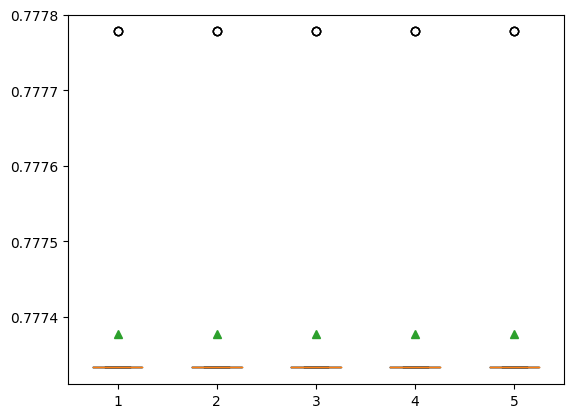

In [426]:
def evaluate_model_filtered(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, df_fs_cat, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores


num_features = [i+1 for i in range(df_fs_cat.shape[1])]

results = list()
for k in num_features:

    model = LogisticRegression(solver='liblinear')
    fs = SelectKBest(score_func=mutual_info_classif, k=k)
    pipeline = Pipeline(steps=[('mut',fs), ('lr', model)])

    scores = evaluate_model_filtered(pipeline)
    results.append(scores)

    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))

pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

In [427]:
fs = SelectKBest(score_func=mutual_info_classif, k=3)
fs.fit(df_fs_cat, y)
print(df_fs_cat.columns[fs.get_support()])
X_cat_fs = fs.transform(df_fs_cat)

Index(['EDUCATION', 'AGE_GROUP', 'SEX_MARRIAGE'], dtype='object')


In [428]:
X_cat_fs_df = pd.DataFrame(X_cat_fs, columns=df_fs_cat.columns[fs.get_support()])
X_cat_fs_df

,EDUCATION,AGE_GROUP,SEX_MARRIAGE
0,3,3,2
1,2,1,2
2,2,4,5
3,2,5,4
4,2,4,5
...,...,...,...
22495,2,3,2
22496,1,4,2
22497,1,1,2
22498,2,1,5


>1 0.820 (0.003)
>2 0.820 (0.004)
>3 0.820 (0.004)
>4 0.815 (0.005)
>5 0.814 (0.006)
>6 0.815 (0.005)
>7 0.777 (0.000)
>8 0.777 (0.000)
>9 0.777 (0.000)
>10 0.777 (0.000)
>11 0.777 (0.000)
>12 0.777 (0.000)
>13 0.777 (0.000)
>14 0.777 (0.000)
>15 0.777 (0.000)
>16 0.777 (0.000)
>17 0.777 (0.000)
>18 0.777 (0.000)
>19 0.777 (0.000)
>20 0.778 (0.003)
>21 0.777 (0.000)
>22 0.777 (0.000)
>23 0.777 (0.001)
>24 0.777 (0.000)
>25 0.777 (0.000)
>26 0.777 (0.000)
>27 0.777 (0.000)
>28 0.777 (0.000)
>29 0.777 (0.000)
>30 0.777 (0.000)
>31 0.777 (0.000)


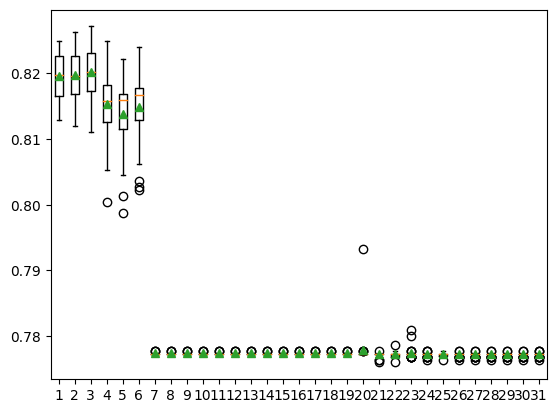

In [429]:
def evaluate_model_filtered(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, df_fs_num, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

num_features = [i+1 for i in range(df_fs_num.shape[1])]

results = list()
for k in num_features:
    model = LogisticRegression(solver='liblinear')
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])

    scores = evaluate_model_filtered(pipeline)
    results.append(scores)

    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))

pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

In [430]:
fs = SelectKBest(score_func=f_classif, k=5)
fs.fit(df_fs_num, y)
print(df_fs_num.columns[fs.get_support()])
X_num_fs = fs.transform(df_fs_num)

Index(['PAY_SEPT', 'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY'], dtype='object')


In [431]:
X_num_fs_df = pd.DataFrame(X_num_fs, columns=df_fs_num.columns[fs.get_support()])
X_num_fs_df

,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
22495,0.0,0.0,0.0,0.0,0.0
22496,2.0,2.0,2.0,2.0,2.0
22497,0.0,0.0,0.0,0.0,0.0
22498,0.0,0.0,0.0,0.0,2.0


In [432]:
X_fs_df = pd.concat([X_cat_fs_df, X_num_fs_df], axis=1)
X_fs_df

,EDUCATION,AGE_GROUP,SEX_MARRIAGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY
0,3,3,2,0.0,0.0,0.0,0.0,0.0
1,2,1,2,0.0,0.0,0.0,0.0,0.0
2,2,4,5,0.0,0.0,0.0,0.0,0.0
3,2,5,4,1.0,0.0,0.0,0.0,0.0
4,2,4,5,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
22495,2,3,2,0.0,0.0,0.0,0.0,0.0
22496,1,4,2,2.0,2.0,2.0,2.0,2.0
22497,1,1,2,0.0,0.0,0.0,0.0,0.0
22498,2,1,5,0.0,0.0,0.0,0.0,2.0


In [433]:
df_fs_completed = pd.concat([X_fs_df, y], axis=1)
df_fs_completed

,EDUCATION,AGE_GROUP,SEX_MARRIAGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,WILL_DEFAULT
0,3,3,2,0.0,0.0,0.0,0.0,0.0,0
1,2,1,2,0.0,0.0,0.0,0.0,0.0,0
2,2,4,5,0.0,0.0,0.0,0.0,0.0,0
3,2,5,4,1.0,0.0,0.0,0.0,0.0,0
4,2,4,5,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
22495,2,3,2,0.0,0.0,0.0,0.0,0.0,0
22496,1,4,2,2.0,2.0,2.0,2.0,2.0,1
22497,1,1,2,0.0,0.0,0.0,0.0,0.0,0
22498,2,1,5,0.0,0.0,0.0,0.0,2.0,1


In [434]:
df_fs_completed.to_csv('FS_filter.csv')

In [435]:
test = load_dataset('test.csv', index='ID')
test = test[df_fs_completed.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [436]:
df_fs_filter_model = evaluate_data_using_tree('FS_filter.csv', verbose=2, test_data=(X_test, y_test))


Compare train-test accuracy for overfitting...

     Metric     Train    Test
0  Accuracy  0.817111  0.8172

Displaying evaluation metrics on model...

      Metric      Test
0   Accuracy  0.817200
1  Precision  0.318992
2     Recall  0.663683
3         f1  0.430884
4  ROC Score  0.749376


#### Feature Selection using RFE

In [409]:
df_fs_RFE = pd.read_csv('train.csv', index_col='ID')
df_fs_RFE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22500 entries, 21178 to 23655
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LIMIT_BAL       22500 non-null  int64  
 1   SEX             22500 non-null  int64  
 2   EDUCATION       22500 non-null  int64  
 3   MARRIAGE        22500 non-null  int64  
 4   AGE             22500 non-null  int64  
 5   PAY_SEPT        22500 non-null  int64  
 6   PAY_AUG         22500 non-null  int64  
 7   PAY_JUL         22500 non-null  int64  
 8   PAY_JUN         22500 non-null  int64  
 9   PAY_MAY         22500 non-null  int64  
 10  PAY_APR         22500 non-null  int64  
 11  BILL_AMT_SEPT   22500 non-null  int64  
 12  BILL_AMT_AUG    22500 non-null  int64  
 13  BILL_AMT_JUL    22500 non-null  int64  
 14  BILL_AMT_JUN    22500 non-null  int64  
 15  BILL_AMT_MAY    22500 non-null  int64  
 16  BILL_AMT_APR    22500 non-null  int64  
 17  PAY_AMT_SEPT    22500 non-n

In [410]:
y = df_fs_RFE['WILL_DEFAULT']
y = pd.DataFrame(y)
X = df_fs_RFE.drop(['WILL_DEFAULT'], axis=1, inplace=False)

Optimal number of features : 29
Best features : Index(['LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_SEPT', 'PAY_AUG', 'BILL_AMT_SEPT',
       'BILL_AMT_AUG', 'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY',
       'BILL_AMT_APR', 'PAY_AMT_SEPT', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
       'PAY_AMT_JUN', 'PAY_AMT_MAY', 'PAY_AMT_APR', 'SEX_MARRIAGE',
       'AVG_EXP_AUG', 'AVG_EXP_JUL', 'AVG_EXP_JUN', 'AVG_EXP_MAY',
       'AVG_EXP_APR', 'NET_LIMIT_SEPT', 'NET_LIMIT_AUG', 'NET_LIMIT_JUL',
       'NET_LIMIT_JUN', 'NET_LIMIT_MAY', 'NET_LIMIT_APR'],
      dtype='object')
Original features : Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_SEPT',
       'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR', 'BILL_AMT_SEPT',
       'BILL_AMT_AUG', 'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY',
       'BILL_AMT_APR', 'PAY_AMT_SEPT', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
       'PAY_AMT_JUN', 'PAY_AMT_MAY', 'PAY_AMT_APR', 'SEX_MARRIAGE',
       'AGE_GROUP', 'AVG_EXP_AUG', 'AVG_EXP_JUL', 'AVG_EXP_JUN',

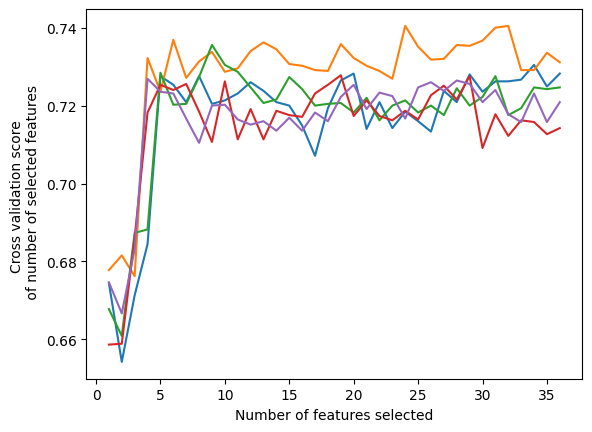

In [411]:
rfecv = RFECV(estimator=DecisionTreeClassifier(), 
              cv=KFold(), 
              scoring='accuracy')

rfecv.fit(X, y)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [412]:
for i in range(X.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X.columns[i], rfecv.support_[i], rfecv.ranking_[i]))

Column: LIMIT_BAL, Selected True, Rank: 1.000
Column: SEX, Selected False, Rank: 7.000
Column: EDUCATION, Selected True, Rank: 1.000
Column: MARRIAGE, Selected False, Rank: 4.000
Column: AGE, Selected True, Rank: 1.000
Column: PAY_SEPT, Selected True, Rank: 1.000
Column: PAY_AUG, Selected True, Rank: 1.000
Column: PAY_JUL, Selected False, Rank: 8.000
Column: PAY_JUN, Selected False, Rank: 2.000
Column: PAY_MAY, Selected False, Rank: 6.000
Column: PAY_APR, Selected False, Rank: 5.000
Column: BILL_AMT_SEPT, Selected True, Rank: 1.000
Column: BILL_AMT_AUG, Selected True, Rank: 1.000
Column: BILL_AMT_JUL, Selected True, Rank: 1.000
Column: BILL_AMT_JUN, Selected True, Rank: 1.000
Column: BILL_AMT_MAY, Selected True, Rank: 1.000
Column: BILL_AMT_APR, Selected True, Rank: 1.000
Column: PAY_AMT_SEPT, Selected True, Rank: 1.000
Column: PAY_AMT_AUG, Selected True, Rank: 1.000
Column: PAY_AMT_JUL, Selected True, Rank: 1.000
Column: PAY_AMT_JUN, Selected True, Rank: 1.000
Column: PAY_AMT_MAY, Sel

In [413]:
rfecv.support_

array([ True, False,  True, False,  True,  True,  True, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [414]:
X_fs = X[X.columns[rfecv.support_]]
X_fs.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_SEPT,PAY_AUG,BILL_AMT_SEPT,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,...,AVG_EXP_JUL,AVG_EXP_JUN,AVG_EXP_MAY,AVG_EXP_APR,NET_LIMIT_SEPT,NET_LIMIT_AUG,NET_LIMIT_JUL,NET_LIMIT_JUN,NET_LIMIT_MAY,NET_LIMIT_APR
ID,,,,,,,,,,,,,,,,,,,,,
21178,300000,3,31,0,0,80928,82690,84462,86263,87238,...,0.019390,0.018594,0.017675,0.017765,0.730240,0.724367,0.718460,0.712457,0.709207,0.702747
23943,20000,2,24,0,0,15730,16776,35036,14694,16914,...,0.635400,0.184567,0.216175,0.146280,0.213500,0.161200,-0.751800,0.265300,0.154300,0.296300
1248,90000,2,35,0,0,2667,2667,0,0,0,...,-0.014817,-0.009878,-0.007408,-0.005927,0.970367,0.970367,1.000000,1.000000,1.000000,1.000000
23623,300000,2,40,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
28455,70000,2,36,0,0,68028,67864,59165,29314,28844,...,-0.036043,-0.160552,-0.117754,-0.088786,0.028171,0.030514,0.154786,0.581229,0.587943,0.579386


In [415]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)

rfe.fit(X, y)

for i in range(X.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: LIMIT_BAL, Selected False, Rank: 10.000
Column: SEX, Selected False, Rank: 31.000
Column: EDUCATION, Selected False, Rank: 24.000
Column: MARRIAGE, Selected False, Rank: 30.000
Column: AGE, Selected False, Rank: 5.000
Column: PAY_SEPT, Selected True, Rank: 1.000
Column: PAY_AUG, Selected False, Rank: 15.000
Column: PAY_JUL, Selected False, Rank: 32.000
Column: PAY_JUN, Selected False, Rank: 26.000
Column: PAY_MAY, Selected False, Rank: 29.000
Column: PAY_APR, Selected False, Rank: 28.000
Column: BILL_AMT_SEPT, Selected True, Rank: 1.000
Column: BILL_AMT_AUG, Selected False, Rank: 14.000
Column: BILL_AMT_JUL, Selected False, Rank: 21.000
Column: BILL_AMT_JUN, Selected False, Rank: 25.000
Column: BILL_AMT_MAY, Selected False, Rank: 22.000
Column: BILL_AMT_APR, Selected False, Rank: 7.000
Column: PAY_AMT_SEPT, Selected False, Rank: 18.000
Column: PAY_AMT_AUG, Selected False, Rank: 9.000
Column: PAY_AMT_JUL, Selected False, Rank: 8.000
Column: PAY_AMT_JUN, Selected False, Rank: 16.

In [416]:
df_fs_completed = pd.concat([X_fs, y], axis=1)
df_fs_completed

,LIMIT_BAL,EDUCATION,AGE,PAY_SEPT,PAY_AUG,BILL_AMT_SEPT,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,...,AVG_EXP_JUN,AVG_EXP_MAY,AVG_EXP_APR,NET_LIMIT_SEPT,NET_LIMIT_AUG,NET_LIMIT_JUL,NET_LIMIT_JUN,NET_LIMIT_MAY,NET_LIMIT_APR,WILL_DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
21178,300000,3,31,0,0,80928,82690,84462,86263,87238,...,0.018594,0.017675,0.017765,0.730240,0.724367,0.718460,0.712457,0.709207,0.702747,0
23943,20000,2,24,0,0,15730,16776,35036,14694,16914,...,0.184567,0.216175,0.146280,0.213500,0.161200,-0.751800,0.265300,0.154300,0.296300,0
1248,90000,2,35,0,0,2667,2667,0,0,0,...,-0.009878,-0.007408,-0.005927,0.970367,0.970367,1.000000,1.000000,1.000000,1.000000,0
23623,300000,2,40,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
28455,70000,2,36,0,0,68028,67864,59165,29314,28844,...,-0.160552,-0.117754,-0.088786,0.028171,0.030514,0.154786,0.581229,0.587943,0.579386,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29803,50000,2,32,0,0,52475,53600,55739,55957,29238,...,0.054300,-0.087200,0.131448,-0.049500,-0.072000,-0.114780,-0.119140,0.415240,0.877620,0
5391,200000,1,37,2,2,157131,166590,168386,164182,169029,...,0.034252,0.039247,0.038453,0.214345,0.167050,0.158070,0.179090,0.154855,0.139580,1
861,50000,1,26,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0


In [417]:
X.columns[rfe.support_]

Index(['PAY_SEPT', 'BILL_AMT_SEPT', 'AVG_EXP_JUL', 'AVG_EXP_APR',
       'NET_LIMIT_SEPT'],
      dtype='object')

In [418]:
df_fs_completed.to_csv('FS_rfe.csv')

In [420]:
test = load_dataset('test.csv', index='ID')
test = test[df_fs_completed.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [421]:
df_fs_rfe = evaluate_data_using_tree('FS_rfe.csv', verbose=2, test_data=(X_test, y_test))


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.818844  0.817067

Displaying evaluation metrics on model...

      Metric      Test
0   Accuracy  0.817067
1  Precision  0.321451
2     Recall  0.661188
3         f1  0.432589
4  ROC Score  0.748317


#### Feature Selection using BorutoPy

In [392]:
df_fs_BP = pd.read_csv('train.csv')
df_fs_BP.drop(['ID'], axis=1, inplace=True)

In [393]:
y = df_fs_BP['WILL_DEFAULT']
X = df_fs_BP.drop(['WILL_DEFAULT'], axis=1, inplace=False)
columns = X.columns

In [394]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [395]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight={1:ratio, 0:1}

In [396]:
forest = RandomForestClassifier(n_jobs=-1, class_weight=class_weight, max_depth=5)
forest.fit(X_scaled, y)

RandomForestClassifier(class_weight={0: 1, 1: 3.4919145538031544}, max_depth=5,
                       n_jobs=-1)

In [397]:
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

In [398]:
feat_selector.fit(X_scaled, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	4
I

BorutaPy(estimator=RandomForestClassifier(class_weight={0: 1,
                                                        1: 3.4919145538031544},
                                          max_depth=5, n_estimators=157,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2B708CC40),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x2B708CC40,
         verbose=2)

In [399]:
X_fs_col = X.columns[feat_selector.support_]
X_fs_col

Index(['LIMIT_BAL', 'PAY_SEPT', 'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY',
       'PAY_APR', 'BILL_AMT_SEPT', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
       'BILL_AMT_JUN', 'BILL_AMT_MAY', 'BILL_AMT_APR', 'PAY_AMT_SEPT',
       'PAY_AMT_AUG', 'PAY_AMT_JUL', 'PAY_AMT_JUN', 'PAY_AMT_MAY',
       'PAY_AMT_APR', 'AVG_EXP_AUG', 'AVG_EXP_JUL', 'AVG_EXP_JUN',
       'AVG_EXP_MAY', 'AVG_EXP_APR', 'NET_LIMIT_SEPT', 'NET_LIMIT_AUG',
       'NET_LIMIT_JUL', 'NET_LIMIT_JUN', 'NET_LIMIT_MAY', 'NET_LIMIT_APR'],
      dtype='object')

In [400]:
len(X_fs_col)

30

In [401]:
# check ranking of features
feat_selector.ranking_

array([1, 7, 3, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [402]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_scaled)
X_filtered

array([[ 1.02364883, -0.46897879, -0.3996997 , ...,  0.189927  ,
         0.1174557 ,  0.06146709],
       [-1.13798895, -0.46897879, -0.3996997 , ..., -1.01952406,
        -1.46018515, -1.11278696],
       [-0.59757951, -0.46897879, -0.3996997 , ...,  0.96766244,
         0.94420273,  0.92025364],
       ...,
       [-0.90638491, -0.46897879, -0.3996997 , ...,  0.96766244,
         0.94420273,  0.92025364],
       [-0.75198221, -0.46897879, -0.3996997 , ..., -0.38943111,
        -0.21873648, -0.23698515],
       [-0.05717006, -0.46897879, -0.3996997 , ...,  0.91804701,
         0.91571868,  0.66513045]])

In [403]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(df_fs, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: LIMIT_BAL                 Rank: 1,  Keep: True
Feature: SEX                       Rank: 7,  Keep: False
Feature: EDUCATION                 Rank: 3,  Keep: False
Feature: MARRIAGE                  Rank: 6,  Keep: False
Feature: AGE                       Rank: 2,  Keep: False
Feature: PAY_SEPT                  Rank: 1,  Keep: True
Feature: PAY_AUG                   Rank: 1,  Keep: True
Feature: PAY_JUL                   Rank: 1,  Keep: True
Feature: PAY_JUN                   Rank: 1,  Keep: True
Feature: PAY_MAY                   Rank: 1,  Keep: True
Feature: PAY_APR                   Rank: 1,  Keep: True
Feature: BILL_AMT_SEPT             Rank: 1,  Keep: True
Feature: BILL_AMT_AUG              Rank: 1,  Keep: True
Feature: BILL_AMT_JUL              Rank: 1,  Keep: True
Feature: BILL_AMT_JUN              Rank: 1,  Keep: True
Feature: BILL_AMT_MAY              Rank: 1,  Keep: True
Feature: BILL_AMT_APR              Rank: 1,  Keep: True
Feature: PAY_AMT_SEPT              Rank: 1, 

In [404]:
X_fs = X[X_fs_col]

In [405]:
df_fs_completed = pd.concat([X_fs, y], axis=1)
df_fs_completed

,LIMIT_BAL,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR,BILL_AMT_SEPT,BILL_AMT_AUG,BILL_AMT_JUL,...,AVG_EXP_JUN,AVG_EXP_MAY,AVG_EXP_APR,NET_LIMIT_SEPT,NET_LIMIT_AUG,NET_LIMIT_JUL,NET_LIMIT_JUN,NET_LIMIT_MAY,NET_LIMIT_APR,WILL_DEFAULT
0,300000,0,0,0,0,0,0,80928,82690,84462,...,0.018594,0.017675,0.017765,0.730240,0.724367,0.718460,0.712457,0.709207,0.702747,0
1,20000,0,0,0,0,0,0,15730,16776,35036,...,0.184567,0.216175,0.146280,0.213500,0.161200,-0.751800,0.265300,0.154300,0.296300,0
2,90000,0,0,0,0,0,0,2667,2667,0,...,-0.009878,-0.007408,-0.005927,0.970367,0.970367,1.000000,1.000000,1.000000,1.000000,0
3,300000,1,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
4,70000,0,0,0,0,0,0,68028,67864,59165,...,-0.160552,-0.117754,-0.088786,0.028171,0.030514,0.154786,0.581229,0.587943,0.579386,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,50000,0,0,0,0,0,0,52475,53600,55739,...,0.054300,-0.087200,0.131448,-0.049500,-0.072000,-0.114780,-0.119140,0.415240,0.877620,0
22496,200000,2,2,2,2,2,2,157131,166590,168386,...,0.034252,0.039247,0.038453,0.214345,0.167050,0.158070,0.179090,0.154855,0.139580,1
22497,50000,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
22498,70000,0,0,0,0,2,2,73939,70488,51152,...,-0.148176,-0.134307,-0.105714,-0.056271,-0.006971,0.269257,0.498257,0.590957,0.599443,1


In [406]:
df_fs_completed.to_csv('FS_boruta.csv')

In [407]:
test = load_dataset('test.csv', index='ID')
test = test[df_fs_completed.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [408]:
df_fs_boruta = evaluate_data_using_tree('FS_boruta.csv', verbose=2, test_data=(X_test, y_test))


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.818711  0.817867

Displaying evaluation metrics on model...

      Metric      Test
0   Accuracy  0.817867
1  Precision  0.324524
2     Recall  0.664151
3         f1  0.436003
4  ROC Score  0.750122


#### Embedded Method

In [458]:
train = load_dataset('train.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

In [459]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight={1:ratio, 0:1}

In [460]:
raw_cat_features = [
    "EDUCATION", "MARRIAGE", "SEX_MARRIAGE", "AGE_GROUP",
]

categorical_features = [col for col in X_train.columns if col in raw_cat_features]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')

numeric_features = [col for col in X_train.columns if col not in categorical_features]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # ("cat", categorical_transformer, categorical_features),
    ]
)

In [461]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('model', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight=class_weight
    ))])

param_grid = {
  'model__n_estimators': [100,150,200], 
  'model__max_depth': [10,20,30]}

In [462]:
%time grid_search = grid_search_with_cross_val(pipeline, param_grid, X_train, y_train)

CPU times: user 5.96 s, sys: 364 ms, total: 6.32 s
Wall time: 6min 2s



Revealing most important features...

           feature     value  abs_value colors
3         MARRIAGE  0.201686   0.201686  green
4              AGE  0.098192   0.098192  green
5         PAY_SEPT  0.048389   0.048389  green
6          PAY_AUG  0.042082   0.042082  green
15    BILL_AMT_MAY  0.034151   0.034151  green
0        LIMIT_BAL  0.031366   0.031366  green
16    BILL_AMT_APR  0.030745   0.030745  green
7          PAY_JUL  0.028700   0.028700  green
27     AVG_EXP_JUN  0.027952   0.027952  green
26     AVG_EXP_JUL  0.026906   0.026906  green
17    PAY_AMT_SEPT  0.026254   0.026254  green
31   NET_LIMIT_AUG  0.024637   0.024637  green
9          PAY_MAY  0.024260   0.024260  green
28     AVG_EXP_MAY  0.024234   0.024234  green
18     PAY_AMT_AUG  0.022393   0.022393  green
29     AVG_EXP_APR  0.022247   0.022247  green
25     AVG_EXP_AUG  0.022189   0.022189  green
30  NET_LIMIT_SEPT  0.021526   0.021526  green
21     PAY_AMT_MAY  0.020996   0.020996  green
10         PAY_APR  0

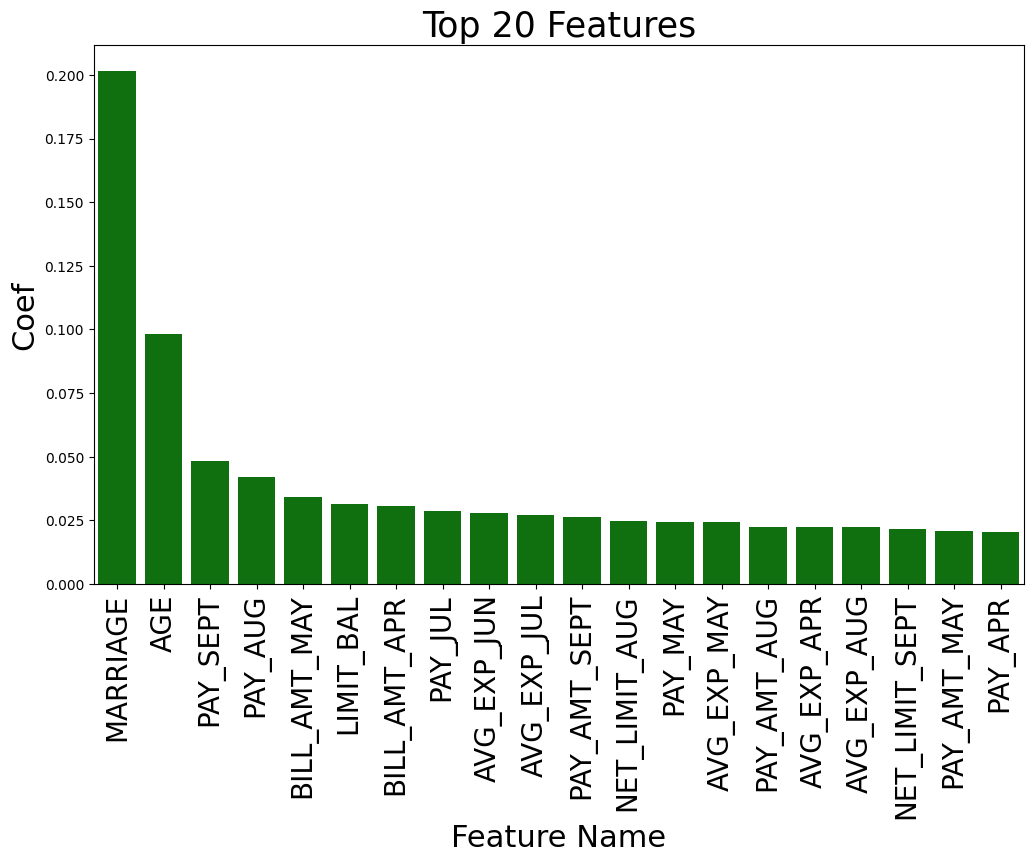

In [465]:
feature_importance(optimal_rfc, X_train)

In [466]:
# Get features with more than a certain threehold
X_fs_embed_columns = [
    'MARRIAGE', 'AGE', 'PAY_SEPT', 'PAY_AUG', 'BILL_AMT_MAY',
    'LIMIT_BAL', 'BILL_AMT_APR', 'PAY_JUL', 'AVG_EXP_JUN', 'AVG_EXP_JUL',
    'PAY_AMT_SEPT', 'NET_LIMIT_AUG', 'PAY_MAY', 'AVG_EXP_MAY', 'PAY_AMT_AUG',
    'AVG_EXP_APR', 'AVG_EXP_AUG', 'NET_LIMIT_SEPT', 'PAY_AMT_MAY', 'PAY_APR'
]
X_fs_embed = X_train[X_fs_embed_columns]

In [467]:
df_fs_completed = pd.concat([X_fs_embed, y_train], axis=1)
df_fs_completed

,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,BILL_AMT_MAY,LIMIT_BAL,BILL_AMT_APR,PAY_JUL,AVG_EXP_JUN,AVG_EXP_JUL,...,NET_LIMIT_AUG,PAY_MAY,AVG_EXP_MAY,PAY_AMT_AUG,AVG_EXP_APR,AVG_EXP_AUG,NET_LIMIT_SEPT,PAY_AMT_MAY,PAY_APR,WILL_DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
21178,2,31,0,0,87238,300000,89176,0,0.018594,0.019390,...,0.724367,0,0.017675,4000,0.017765,0.019207,0.730240,3500,0,0
23943,2,24,0,0,16914,20000,14074,0,0.184567,0.635400,...,0.161200,0,0.216175,2110,0.146280,0.157800,0.213500,4000,0,0
1248,2,35,0,0,0,90000,0,0,-0.009878,-0.014817,...,0.970367,0,-0.007408,0,-0.005927,0.000000,0.970367,0,0,0
23623,1,40,1,0,0,300000,0,0,0.000000,0.000000,...,1.000000,0,0.000000,0,0.000000,0.000000,1.000000,0,0,0
28455,2,36,0,0,28844,70000,29443,0,-0.160552,-0.036043,...,0.030514,0,-0.117754,2044,-0.088786,0.026857,0.028171,1215,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29803,2,32,0,0,29238,50000,6119,0,0.054300,0.078550,...,-0.072000,0,-0.087200,3000,0.131448,0.082500,-0.049500,1134,0,0
5391,2,37,2,2,169029,200000,172084,2,0.034252,0.043138,...,0.167050,2,0.039247,6000,0.038453,0.077295,0.214345,6000,2,1
861,2,26,0,0,0,50000,0,0,0.000000,0.000000,...,1.000000,0,0.000000,0,0.000000,0.000000,1.000000,0,0,0


In [468]:
df_fs_completed.to_csv('FS_embed.csv')

In [469]:
test = load_dataset('test.csv', index='ID')
test = test[df_fs_completed.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [470]:
df_fs_embed = evaluate_data_using_tree('FS_embed.csv', verbose=2, test_data=(X_test, y_test))


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.818622  0.816267

Displaying evaluation metrics on model...

      Metric      Test
0   Accuracy  0.816267
1  Precision  0.315304
2     Recall  0.660232
3         f1  0.426789
4  ROC Score  0.747266


#### Comparison

In [485]:
train_accuracy, test_accuracy, precision_score, recall_score, f1_score = ([] for _ in range(5))

models = [
    ('FE.csv', df_fe_model), 
    ('FS_filter.csv', df_fs_filter_model), 
    ('FS_rfe.csv', df_fs_rfe), 
    ('FS_boruta.csv', df_fs_boruta), 
    ('FS_embed.csv', df_fs_embed)
]

In [486]:
for path, model in models: 
    
    train = load_dataset(path, index='ID')
    X_train, y_train = split_dataset(train, 'WILL_DEFAULT')
    
    test = load_dataset('test.csv', index='ID')
    
    test = test[train.columns]
    
    X_test, y_test = split_dataset(test, 'WILL_DEFAULT')
    
    
    train_prediction = model.predict(X_train)
    train_acc = accuracy_score(train_prediction, y_train)

    test_prediction = model.predict(X_test)
    test_acc = accuracy_score(test_prediction, y_test)

    report = classification_report(y_true=y_test, y_pred=test_prediction, output_dict=True)
    
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    precision_score.append(report['1']['precision'])
    recall_score.append(report['1']['recall'])
    f1_score.append(report['1']['f1-score'])

In [489]:
methods = ['None', 'Filter', 'RFE', 'Wrapper', 'Embedded']
pd.DataFrame({'Method': methods, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'Precision Score': precision_score, 'Recall Score': recall_score, 'F1 Score': f1_score })

,Method,Train Accuracy,Test Accuracy,Precision Score,Recall Score,F1 Score
0,None,0.818033,0.816267,0.660232,0.315304,0.426789
1,Filter,0.817111,0.817200,0.663683,0.318992,0.430884
2,RFE,0.818844,0.817067,0.661188,0.321451,0.432589
3,Wrapper,0.818711,0.817867,0.664151,0.324524,0.436003
4,Embedded,0.818622,0.816267,0.660232,0.315304,0.426789


### Model selection
See the recommended steps for parameter estimation and model selection in the following reference: https://www.ritchieng.com/machine-learning-project-student-intervention/

##### Imbalanced Data

In [272]:
df_train = load_dataset('train.csv', index='ID')
X_train, y_train = split_dataset(df_train, 'WILL_DEFAULT')

In [273]:
# Separate majority and minority classes
df_majority = df_train[df_train.WILL_DEFAULT==0]
df_minority = df_train[df_train.WILL_DEFAULT==1]

print(df_majority.WILL_DEFAULT.count())
print("-----------")
print(df_minority.WILL_DEFAULT.count())
print("-----------")
print(df_train.WILL_DEFAULT.value_counts())

17491
-----------
5009
-----------
0    17491
1     5009
Name: WILL_DEFAULT, dtype: int64


In [274]:
# Upsampling minority class
majority_count = df_majority.WILL_DEFAULT.count()

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=majority_count,    # to match majority class
                                 random_state=587) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# Display new class counts
df_upsampled.WILL_DEFAULT.value_counts()

0    17491
1    17491
Name: WILL_DEFAULT, dtype: int64

In [275]:
# Downsampling majority class
minority_count = df_minority.WILL_DEFAULT.count()

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=minority_count,     # to match minority class
                                 random_state=587) # reproducible results
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# Display new class counts
df_downsampled.WILL_DEFAULT.value_counts()

0    5009
1    5009
Name: WILL_DEFAULT, dtype: int64

The upsample has the disadvantage of increasing the likelihood of overfitting since it replicates the minority class event. It usually outperform the downsampling.

The downsample can discard potentially useful information and the sample can be biased, but it helps improving the run time

To create a syntetic sample I want to use the SMOTE algorithm, which is an oversampling method which creates syntetic samples from the minority class instead of creating copies. It selects 2 or more similar instances and perturb them one at a time by random amount. This techniques should avoid overfitting problems but it risks adding noise to the model

In [276]:
# SMOTE
sm = SMOTE(random_state=589)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

34982
17491


##### Logistic Regression

In [313]:
train = load_dataset('FS_boruta.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

test = load_dataset('test.csv', index='ID')
test = test[train.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [314]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight={1:ratio, 0:1}

In [315]:
raw_cat_features = [
    "EDUCATION", "MARRIAGE", "SEX_MARRIAGE", "AGE_GROUP",
]

categorical_features = [col for col in X_train.columns if col in raw_cat_features]
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')

numeric_features = [col for col in X_train.columns if col not in categorical_features]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [316]:
pipeline = Pipeline(steps=[
  ('preprocessing', preprocessor), 
  ('model', LogisticRegression(
    random_state=11,
    max_iter=3000,
    class_weight=class_weight))])

smote_pipeline = imbpipeline(steps=[
    ('smote', SMOTE(random_state=11)),
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(
        random_state=11,
        max_iter=3000))])

param_grid = {
    'model__solver': ['lbfgs'],
    'model__penalty':['l2'], 
    'model__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000] 
}

In [317]:
%time grid_search = grid_search_with_cross_val(pipeline, param_grid, X_train, y_train)
%time grid_search_smote = grid_search_with_cross_val(smote_pipeline, param_grid, X_train, y_train)

CPU times: user 1.25 s, sys: 161 ms, total: 1.41 s
Wall time: 7.28 s
CPU times: user 3.15 s, sys: 696 ms, total: 3.84 s
Wall time: 14.8 s


In [318]:
%time optimal_lr = grid_search_results(grid_search, X_test, y_test)
%time optimal_lr_smote = grid_search_results(grid_search_smote, X_test, y_test)

Cross-validation score: 0.7593927854805133
Test score: 0.7538171987251986
Best parameters: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
CPU times: user 118 ms, sys: 46.6 ms, total: 164 ms
Wall time: 31.8 ms
Cross-validation score: 0.7562422509119365
Test score: 0.7537206038363136
Best parameters: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
CPU times: user 34 ms, sys: 20.7 ms, total: 54.7 ms
Wall time: 10.7 ms


In [319]:
train_class_preds, test_class_preds = evaluate_model(optimal_lr, X_train, X_test, y_train, y_test)
train_class_preds_smote, test_class_preds_smote = evaluate_model(optimal_lr_smote, X_train, X_test, y_train, y_test)


Compare train-test accuracy for overfitting...

     Metric     Train    Test
0  Accuracy  0.778267  0.7764

Generating classification report...

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5873
           1       0.49      0.57      0.52      1627

    accuracy                           0.78      7500
   macro avg       0.68      0.70      0.69      7500
weighted avg       0.79      0.78      0.78      7500


Compare train-test accuracy for overfitting...

     Metric   Train  Test
0  Accuracy  0.7716  0.77

Generating classification report...

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5873
           1       0.48      0.59      0.53      1627

    accuracy                           0.77      7500
   macro avg       0.68      0.71      0.69      7500
weighted avg       0.79      0.77      0.78      7500




Building confusion matrix...

[[14700  2791]
 [ 2198  2811]]


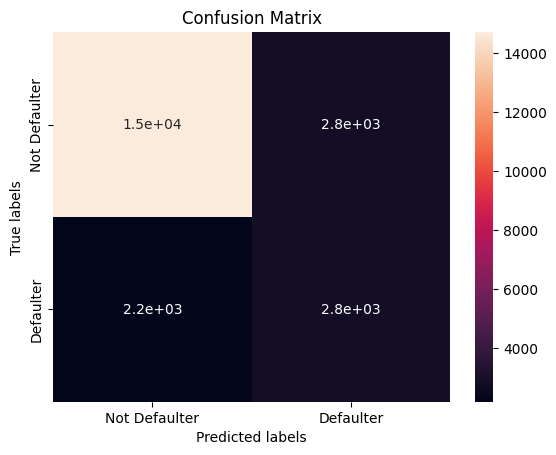

In [320]:
labels = ['Not Defaulter', 'Defaulter']
build_confusion_matrix(y_train, train_class_preds, labels)


Revealing most important features...

           feature     value  abs_value colors
1         PAY_SEPT  0.668140   0.668140  green
25   NET_LIMIT_AUG -0.213408   0.213408    red
24  NET_LIMIT_SEPT  0.182236   0.182236  green
0        LIMIT_BAL -0.162024   0.162024    red
14     PAY_AMT_AUG -0.149061   0.149061    red
13    PAY_AMT_SEPT -0.130079   0.130079    red
9     BILL_AMT_JUL  0.129660   0.129660  green
6          PAY_APR  0.119138   0.119138  green
3          PAY_JUL  0.114147   0.114147  green
4          PAY_JUN  0.103329   0.103329  green
12    BILL_AMT_APR -0.086714   0.086714    red
2          PAY_AUG  0.085986   0.085986  green
29   NET_LIMIT_APR -0.079116   0.079116    red
28   NET_LIMIT_MAY  0.071515   0.071515  green
5          PAY_MAY  0.062370   0.062370  green
18     PAY_AMT_APR -0.055907   0.055907    red
22     AVG_EXP_MAY -0.052683   0.052683    red
23     AVG_EXP_APR  0.045634   0.045634  green
15     PAY_AMT_JUL -0.027070   0.027070    red
19     AVG_EXP_AUG -0

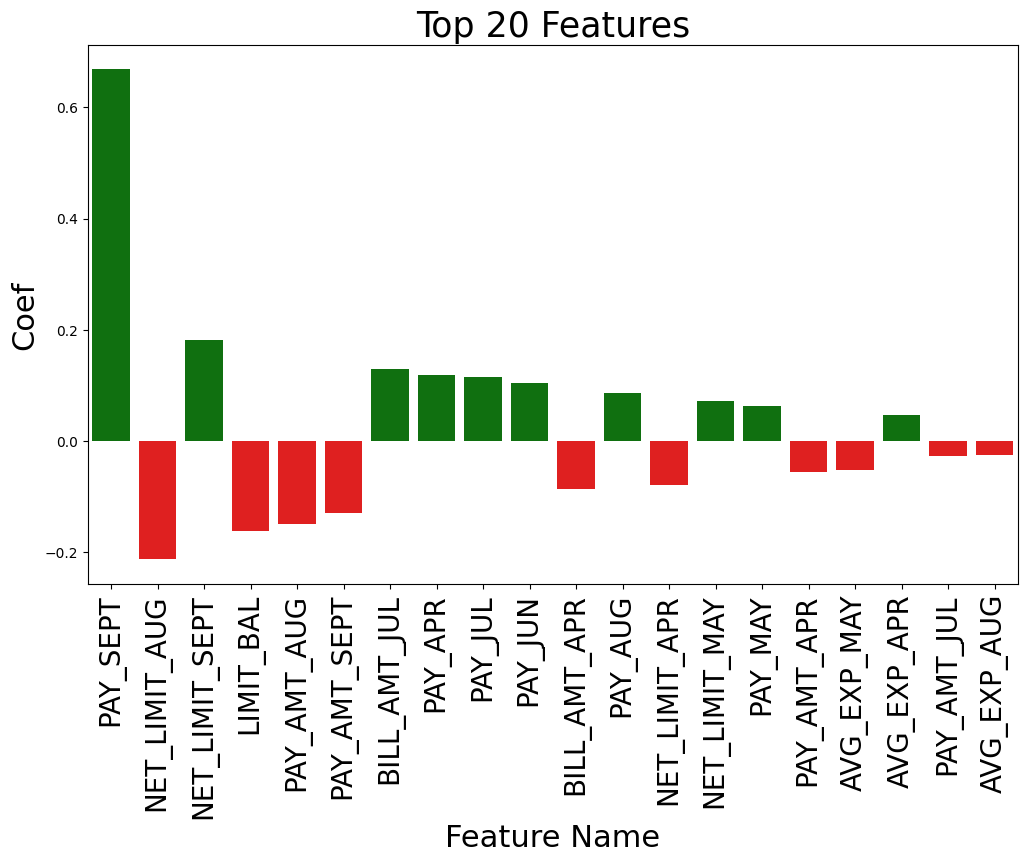

In [321]:
feature_importance(optimal_lr, X_train)


Generating AUC Curve...



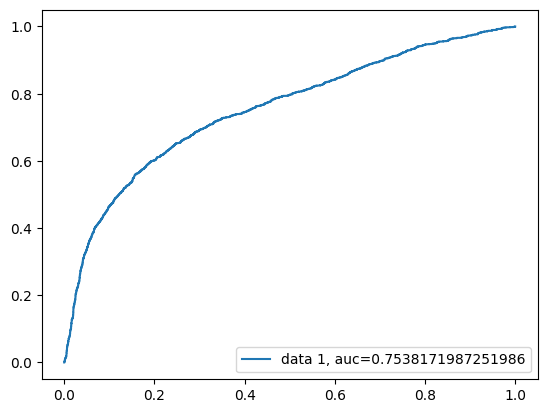

In [322]:
roc_auc_curve(optimal_lr, X_test)

In [323]:
save_model(optimal_lr, 'LR_optimized_classifier')

##### SVC - Linear Model

In [5]:
train = load_dataset('FS_boruta.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

test = load_dataset('test.csv', index='ID')
test = test[train.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [6]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight={1:ratio, 0:1}

In [7]:
raw_cat_features = [
    "EDUCATION", "MARRIAGE", "SEX_MARRIAGE", "AGE_GROUP",
]

categorical_features = [col for col in X_train.columns if col in raw_cat_features]
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')

numeric_features = [col for col in X_train.columns if col not in categorical_features]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [8]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('model', SVC(
        probability=True,
        class_weight=class_weight
    ))])

param_grid = {'model__C': [0.1, 1, 10],
    'model__kernel': ['rbf']}

In [9]:
%time grid_search = grid_search_with_cross_val(pipeline, param_grid, X_train, y_train)

CPU times: user 56.8 s, sys: 594 ms, total: 57.4 s
Wall time: 42min 51s


In [10]:
optimal_svc = grid_search_results(grid_search, X_test, y_test)

Cross-validation score: 0.7646398061640993
Test score: 0.7581364449376167
Best parameters: {'model__C': 0.1, 'model__kernel': 'rbf'}


In [11]:
train_class_preds, test_class_preds = evaluate_model(optimal_svc, X_train, X_test, y_train, y_test)


Compare train-test accuracy for overfitting...

     Metric   Train    Test
0  Accuracy  0.7736  0.7652

Generating classification report...

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      5873
           1       0.47      0.59      0.52      1627

    accuracy                           0.77      7500
   macro avg       0.67      0.70      0.68      7500
weighted avg       0.79      0.77      0.77      7500




Building confusion matrix...

[[14407  3084]
 [ 2010  2999]]


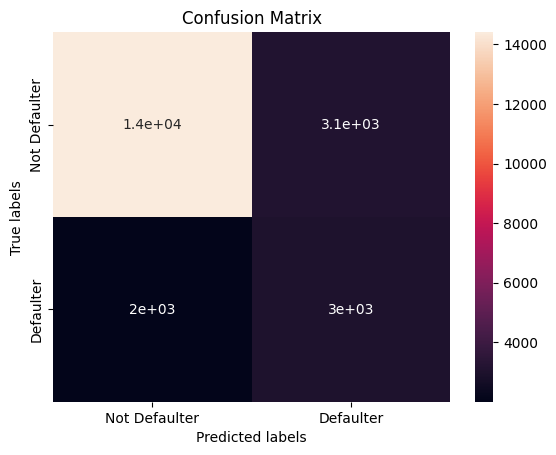

In [12]:
labels = ['Not Defaulter', 'Defaulter']
build_confusion_matrix(y_train, train_class_preds, labels)

In [13]:
feature_importance(optimal_svc, X_train)


Revealing most important features...




Generating AUC Curve...



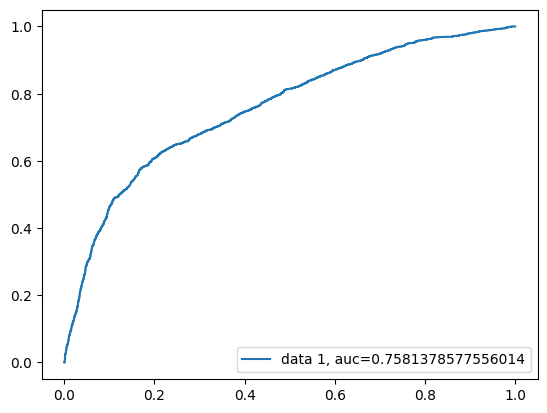

In [14]:
roc_auc_curve(optimal_svc, X_test)

In [15]:
save_model(optimal_svc, 'SVC_optimized_classifier')

#### Decision Tree Classifier - Tree

Decision Tree is another very popular algorithm for classification problems because it is easy to interpret and understand. An internal node represents a feature, the branch represents a decision rule, and each leaf node represents the outcome. Some advantages of decision trees are that they require less data preprocessing, i.e., no need to normalize features. However, noisy data can be easily overfitted and results in biased results when the data set is imbalanced.

In [329]:
train = load_dataset('FS_boruta.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

test = load_dataset('test.csv', index='ID')
test = test[train.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [330]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight={1:ratio, 0:1}

In [331]:
raw_cat_features = [
    "EDUCATION", "MARRIAGE", "SEX_MARRIAGE", "AGE_GROUP",
]

categorical_features = [col for col in X_train.columns if col in raw_cat_features]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # ("cat", categorical_transformer, categorical_features),
    ]
)

In [332]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('model', DecisionTreeClassifier(
        class_weight=class_weight
    ))])

param_grid = {
  'model__max_depth': [20,30,50,100], 
  'model__min_samples_split':[0.1,0.2,0.4]}

In [334]:
%time grid_search = grid_search_with_cross_val(pipeline, param_grid, X_train, y_train)

CPU times: user 1.14 s, sys: 250 ms, total: 1.39 s
Wall time: 15.9 s


In [335]:
optimal_dtc = grid_search_results(grid_search, X_test, y_test)

Cross-validation score: 0.767162662143708
Test score: 0.755479928513503
Best parameters: {'model__max_depth': 100, 'model__min_samples_split': 0.1}


In [336]:
train_class_preds, test_class_preds = evaluate_model(optimal_dtc, X_train, X_test, y_train, y_test)


Compare train-test accuracy for overfitting...

     Metric     Train    Test
0  Accuracy  0.739111  0.7232

Generating classification report...

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      5873
           1       0.41      0.62      0.49      1627

    accuracy                           0.72      7500
   macro avg       0.64      0.69      0.65      7500
weighted avg       0.78      0.72      0.74      7500




Building confusion matrix...

[[13356  4135]
 [ 1735  3274]]


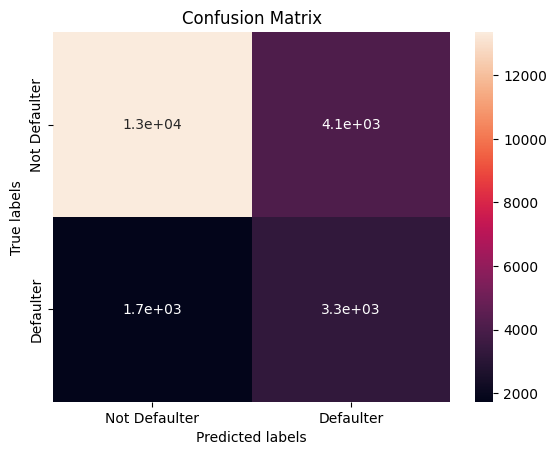

In [337]:
labels = ['Not Defaulter', 'Defaulter']
build_confusion_matrix(y_train, train_class_preds, labels)


Revealing most important features...

           feature     value  abs_value colors
1         PAY_SEPT  0.720431   0.720431  green
14     PAY_AMT_AUG  0.065545   0.065545  green
4          PAY_JUN  0.049836   0.049836  green
2          PAY_AUG  0.038216   0.038216  green
25   NET_LIMIT_AUG  0.030643   0.030643  green
0        LIMIT_BAL  0.019166   0.019166  green
8     BILL_AMT_AUG  0.018283   0.018283  green
19     AVG_EXP_AUG  0.015812   0.015812  green
6          PAY_APR  0.014659   0.014659  green
13    PAY_AMT_SEPT  0.009355   0.009355  green
16     PAY_AMT_JUN  0.006436   0.006436  green
24  NET_LIMIT_SEPT  0.006139   0.006139  green
12    BILL_AMT_APR  0.003632   0.003632  green
5          PAY_MAY  0.001847   0.001847  green
27   NET_LIMIT_JUN  0.000000   0.000000    red
26   NET_LIMIT_JUL  0.000000   0.000000    red
21     AVG_EXP_JUN  0.000000   0.000000    red
28   NET_LIMIT_MAY  0.000000   0.000000    red
23     AVG_EXP_APR  0.000000   0.000000    red
22     AVG_EXP_MAY  0

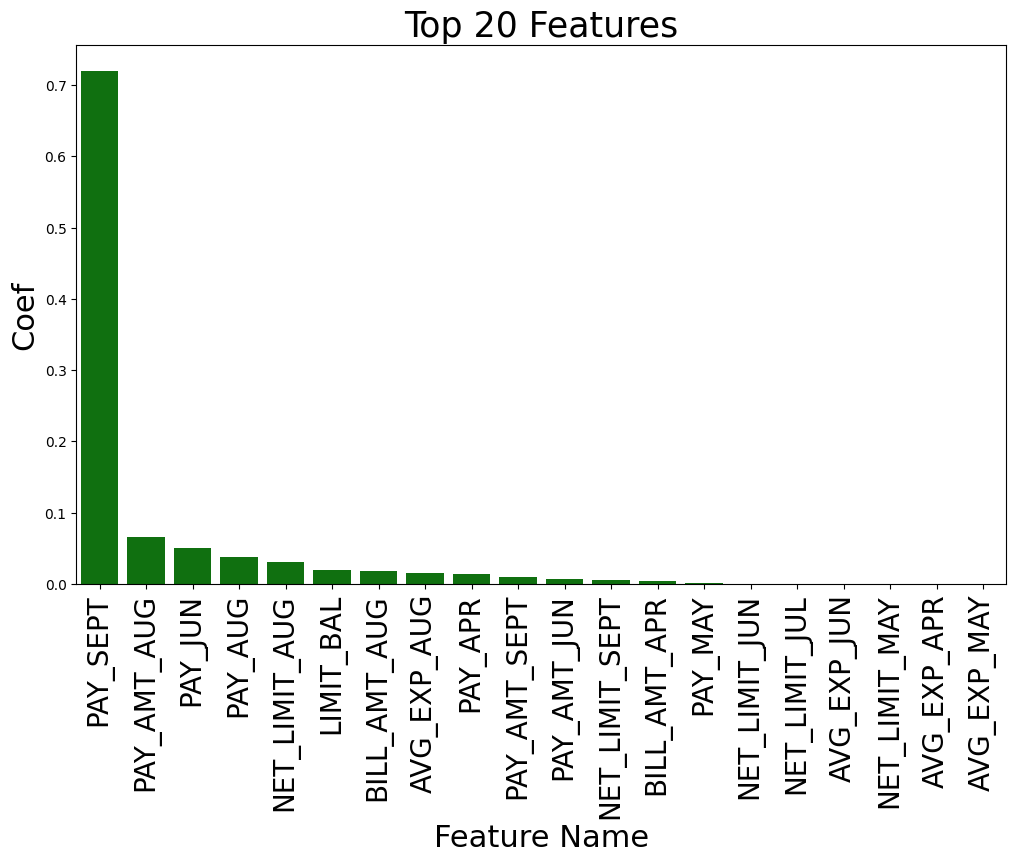

In [338]:
feature_importance(optimal_dtc, X_train)


Generating AUC Curve...



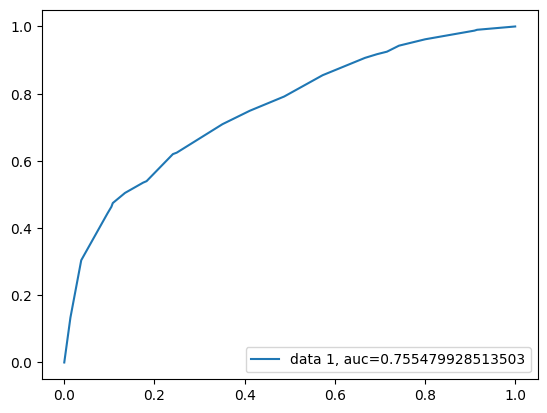

In [339]:
roc_auc_curve(optimal_dtc, X_test)

In [340]:
save_model(optimal_dtc, 'DTC_optimized_classifier')

#### Random Forest Classifier - Tree Ensemble

In [341]:
train = load_dataset('FS_boruta.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

test = load_dataset('test.csv', index='ID')
test = test[train.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [342]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight={1:ratio, 0:1}

In [343]:
raw_cat_features = [
    "EDUCATION", "MARRIAGE", "SEX_MARRIAGE", "AGE_GROUP",
]

categorical_features = [col for col in X_train.columns if col in raw_cat_features]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')

numeric_features = [col for col in X_train.columns if col not in categorical_features]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # ("cat", categorical_transformer, categorical_features),
    ]
)

In [344]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('model', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight=class_weight
    ))])

param_grid = {
  'model__n_estimators': [100,150,200], 
  'model__max_depth': [10,20,30]}

In [346]:
%time grid_search = grid_search_with_cross_val(pipeline, param_grid, X_train, y_train)

CPU times: user 6 s, sys: 240 ms, total: 6.24 s
Wall time: 5min 53s


In [347]:
optimal_rfc = grid_search_results(grid_search, X_test, y_test)

Cross-validation score: 0.7775495850476075
Test score: 0.7726163118103944
Best parameters: {'model__max_depth': 10, 'model__n_estimators': 150}


In [348]:
train_class_preds, test_class_preds = evaluate_model(optimal_rfc, X_train, X_test, y_train, y_test)


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.839956  0.787333

Generating classification report...

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5873
           1       0.51      0.54      0.52      1627

    accuracy                           0.79      7500
   macro avg       0.69      0.70      0.69      7500
weighted avg       0.79      0.79      0.79      7500




Building confusion matrix...

[[15477  2014]
 [ 1587  3422]]


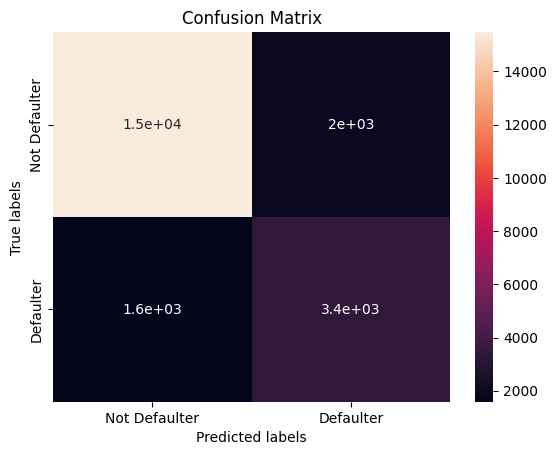

In [349]:
labels = ['Not Defaulter', 'Defaulter']
build_confusion_matrix(y_train, train_class_preds, labels)


Revealing most important features...

           feature     value  abs_value colors
1         PAY_SEPT  0.194207   0.194207  green
2          PAY_AUG  0.100815   0.100815  green
3          PAY_JUL  0.051896   0.051896  green
4          PAY_JUN  0.046671   0.046671  green
13    PAY_AMT_SEPT  0.039154   0.039154  green
25   NET_LIMIT_AUG  0.031783   0.031783  green
0        LIMIT_BAL  0.031158   0.031158  green
24  NET_LIMIT_SEPT  0.030148   0.030148  green
14     PAY_AMT_AUG  0.030106   0.030106  green
5          PAY_MAY  0.026539   0.026539  green
15     PAY_AMT_JUL  0.026318   0.026318  green
7    BILL_AMT_SEPT  0.025683   0.025683  green
19     AVG_EXP_AUG  0.023314   0.023314  green
29   NET_LIMIT_APR  0.023185   0.023185  green
18     PAY_AMT_APR  0.023089   0.023089  green
26   NET_LIMIT_JUL  0.023077   0.023077  green
27   NET_LIMIT_JUN  0.022929   0.022929  green
16     PAY_AMT_JUN  0.022797   0.022797  green
22     AVG_EXP_MAY  0.021127   0.021127  green
20     AVG_EXP_JUL  0

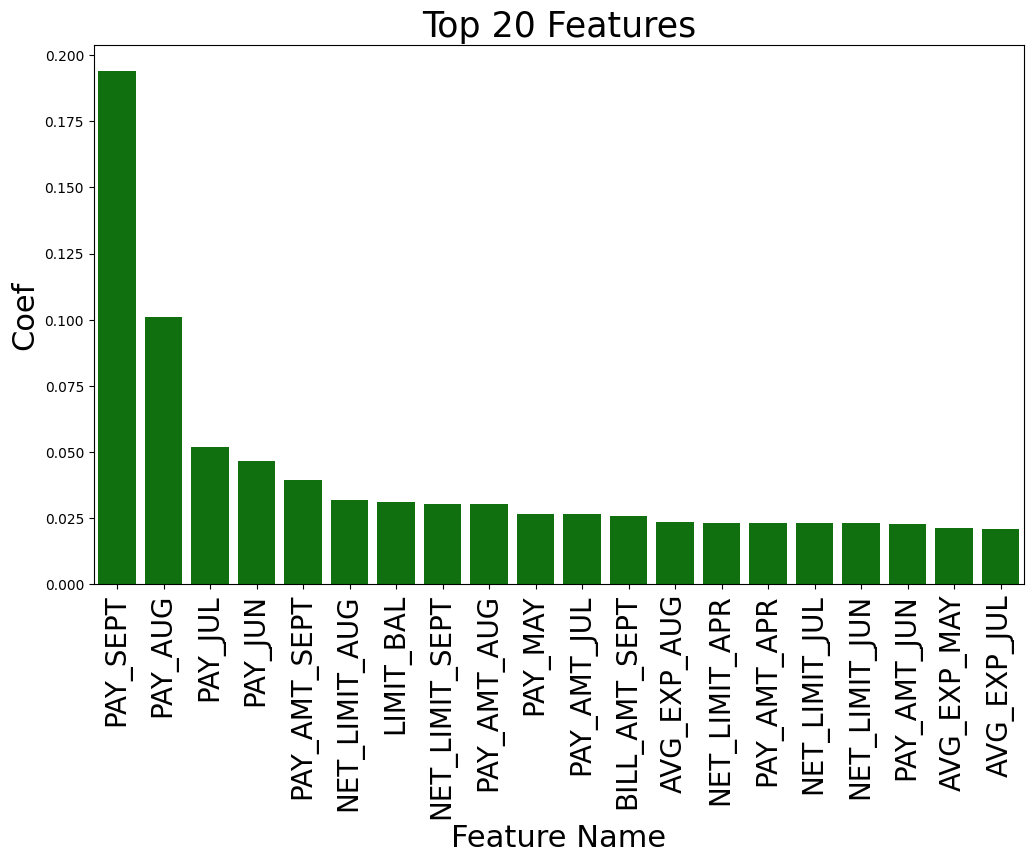

In [350]:
feature_importance(optimal_rfc, X_train)


Generating AUC Curve...



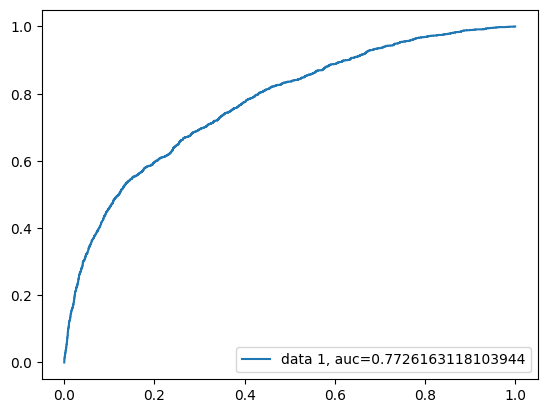

In [351]:
roc_auc_curve(optimal_rfc, X_test)

In [352]:
save_model(optimal_rfc, 'RFC_optimized_classifier')

#### XGBoost - Gradient Boosting Machine

In [501]:
train = load_dataset('FS_boruta.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

test = load_dataset('test.csv', index='ID')
test = test[train.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [502]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight={1:ratio, 0:1}

In [503]:
raw_cat_features = [
    "EDUCATION", "MARRIAGE", "SEX_MARRIAGE", "AGE_GROUP",
]

categorical_features = [col for col in X_train.columns if col in raw_cat_features]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')

numeric_features = [col for col in X_train.columns if col not in categorical_features]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # ("cat", categorical_transformer, categorical_features),
    ]
)

In [504]:
pipeline = imbpipeline(steps=[
    ('smote', SMOTE(random_state=11)),
    ('preprocessing', preprocessor), 
    ('model', XGBClassifier(
        learning_rate =0.1, 
        n_estimators=140, 
        max_depth=10,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27))])

param_grid = {
    'model__learning_rate': [0.01, 0.1, 1],
    'model__max_depth':range(3,10,2),
    'model__min_child_weight':range(1,6,2)
}

In [505]:
%time grid_search = grid_search_with_cross_val(pipeline, param_grid, X_train, y_train)

CPU times: user 22.8 s, sys: 2.31 s, total: 25.1 s
Wall time: 1h 1min 3s


In [506]:
optimal_xgb = grid_search_results(grid_search, X_test, y_test)

Cross-validation score: 0.7716026633339327
Test score: 0.7607631352042741
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 3}


In [507]:
train_class_preds, test_class_preds = evaluate_model(optimal_xgb, X_train, X_test, y_train, y_test)


Compare train-test accuracy for overfitting...

     Metric     Train    Test
0  Accuracy  0.775422  0.7604

Generating classification report...

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5873
           1       0.46      0.57      0.51      1627

    accuracy                           0.76      7500
   macro avg       0.66      0.69      0.67      7500
weighted avg       0.78      0.76      0.77      7500




Building confusion matrix...

[[14427  3064]
 [ 1989  3020]]


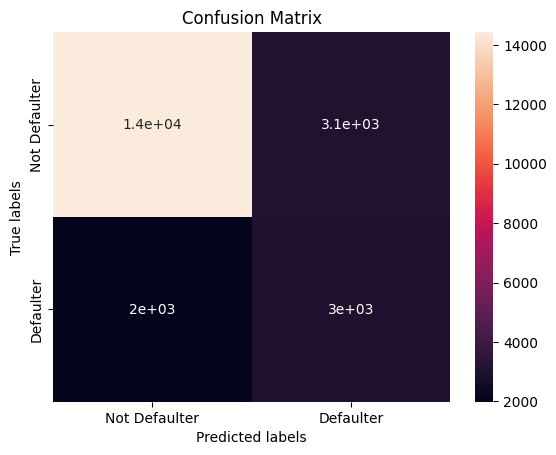

In [508]:
labels = ['Not Defaulter', 'Defaulter']
build_confusion_matrix(y_train, train_class_preds, labels)


Revealing most important features...

           feature     value  abs_value colors
1         PAY_SEPT  0.285158   0.285158  green
2          PAY_AUG  0.098126   0.098126  green
3          PAY_JUL  0.056930   0.056930  green
24  NET_LIMIT_SEPT  0.053606   0.053606  green
16     PAY_AMT_JUN  0.046826   0.046826  green
4          PAY_JUN  0.040749   0.040749  green
13    PAY_AMT_SEPT  0.038741   0.038741  green
15     PAY_AMT_JUL  0.033118   0.033118  green
25   NET_LIMIT_AUG  0.028145   0.028145  green
7    BILL_AMT_SEPT  0.027939   0.027939  green
14     PAY_AMT_AUG  0.024038   0.024038  green
23     AVG_EXP_APR  0.022604   0.022604  green
18     PAY_AMT_APR  0.022562   0.022562  green
5          PAY_MAY  0.019322   0.019322  green
26   NET_LIMIT_JUL  0.019002   0.019002  green
20     AVG_EXP_JUL  0.017946   0.017946  green
10    BILL_AMT_JUN  0.017630   0.017630  green
22     AVG_EXP_MAY  0.015428   0.015428  green
6          PAY_APR  0.014906   0.014906  green
19     AVG_EXP_AUG  0

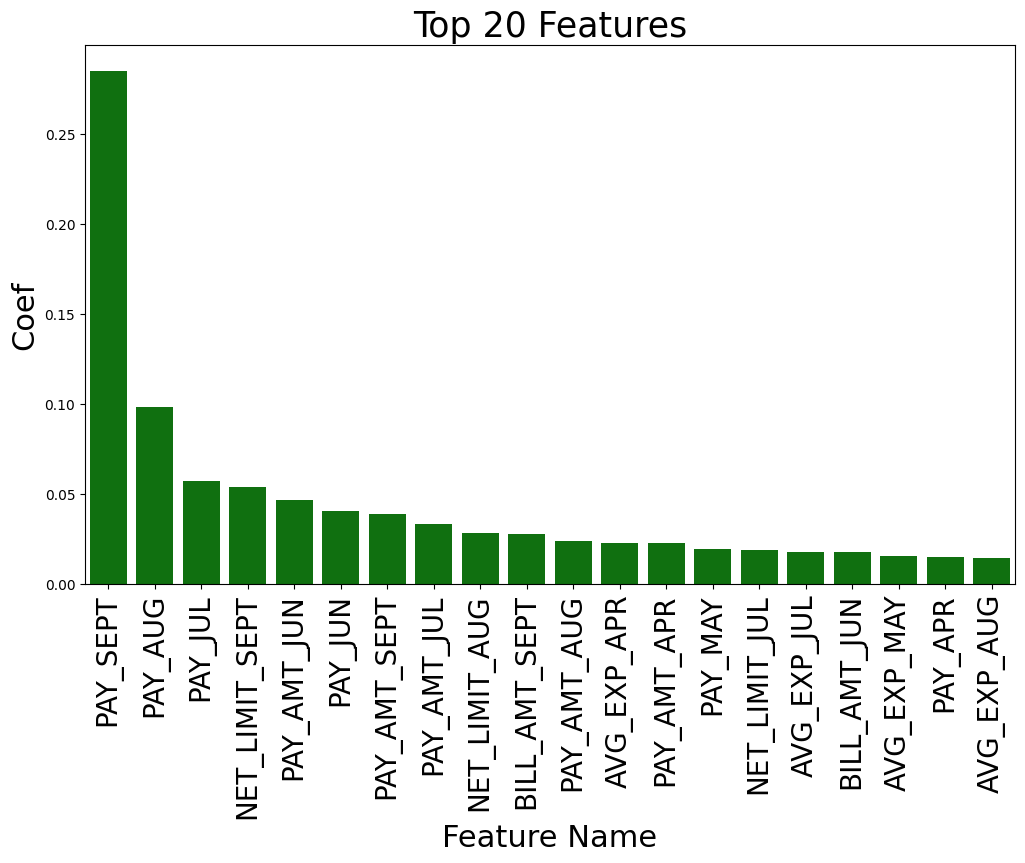

In [509]:
feature_importance(optimal_xgb, X_train)


Generating AUC Curve...



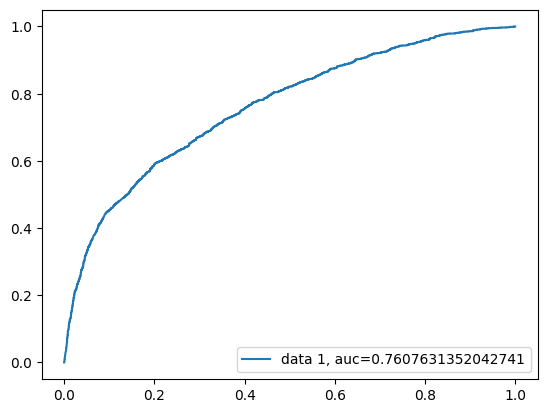

In [510]:
roc_auc_curve(optimal_xgb, X_test)

In [511]:
save_model(optimal_xgb, 'XGB_optimized_classifier')

#### Neural Network - Multi-Layer Perceptron
Using TenserFlow keras
- https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
- https://www.educative.io/answers/implement-neural-network-for-classification-using-scikit-learn
- https://thecleverprogrammer.com/2022/01/10/classification-with-neural-networks-using-python/

In [541]:
train = load_dataset('FS_boruta.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

test = load_dataset('test.csv', index='ID')
test = test[train.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [542]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight={1:ratio, 0:1}

In [543]:
raw_cat_features = [
    "EDUCATION", "MARRIAGE", "SEX_MARRIAGE", "AGE_GROUP",
]

categorical_features = [col for col in X_train.columns if col in raw_cat_features]
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')

numeric_features = [col for col in X_train.columns if col not in categorical_features]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [544]:
model = MLPClassifier(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(5, 2),
    random_state=1,
    max_iter=5000)

pipeline = imbpipeline(steps=[
    ('smote', SMOTE(random_state=11)),
    ('preprocessing', preprocessor), 
    ('model', model)])

param_grid = {
    'model__hidden_layer_sizes': [(10, 5), (2, 1), (20, 8)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam', 'lbfgs'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
}

In [44]:
%%capture
%time grid_search = grid_search_with_cross_val(pipeline, param_grid, X_train, y_train)

In [546]:
optimal_mlp = grid_search_results(grid_search, X_test, y_test)

Cross-validation score: 0.7687228308396793
Test score: 0.7608210084150578
Best parameters: {'model__activation': 'tanh', 'model__alpha': 0.05, 'model__hidden_layer_sizes': (10, 5), 'model__learning_rate': 'adaptive', 'model__solver': 'sgd'}


In [547]:
train_class_preds, test_class_preds = evaluate_model(optimal_mlp, X_train, X_test, y_train, y_test)


Compare train-test accuracy for overfitting...

     Metric     Train      Test
0  Accuracy  0.738089  0.725867

Generating classification report...

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      5873
           1       0.42      0.64      0.50      1627

    accuracy                           0.73      7500
   macro avg       0.65      0.70      0.66      7500
weighted avg       0.78      0.73      0.74      7500




Building confusion matrix...

[[13242  4249]
 [ 1644  3365]]


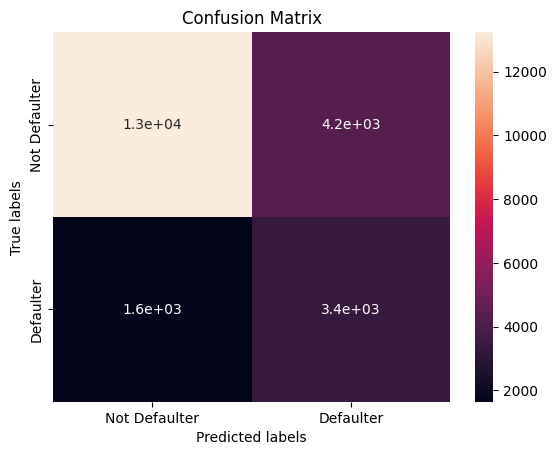

In [548]:
labels = ['Not Defaulter', 'Defaulter']
build_confusion_matrix(y_train, train_class_preds, labels)

In [549]:
feature_importance(optimal_mlp, X_train)


Revealing most important features...




Generating AUC Curve...



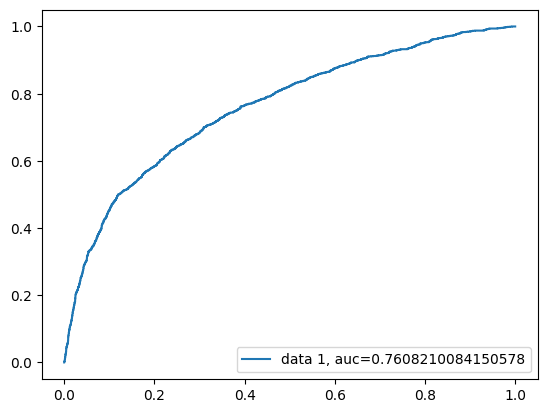

In [550]:
roc_auc_curve(optimal_mlp, X_test)

In [551]:
save_model(optimal_mlp, 'MLP_optimized_classifier')

In [172]:
# plt.plot(optimal_mlp.named_steps['model'].loss_curve_) # only for sgd solver
# plt.title("Loss Curve", fontsize=14)
# plt.xlabel('Iterations')
# plt.ylabel('Cost')
# plt.show()

### Model evaluation
Evaluation metrics explain the performance of a model. An important aspect of evaluation metrics is their capability to discriminate among model results. 

- Lecture 3 notes
- https://www.ritchieng.com/machine-learning-evaluate-classification-model/

In [16]:
train = load_dataset('FS_boruta.csv', index='ID')
X_train, y_train = split_dataset(train, 'WILL_DEFAULT')

test = load_dataset('test.csv', index='ID')
test = test[train.columns]
X_test, y_test = split_dataset(test, 'WILL_DEFAULT')

In [17]:
optimal_lr1 = pickle.load(open('LR_optimized_classifier', 'rb'))
optimal_svc1 = pickle.load(open('SVC_optimized_classifier', 'rb'))
optimal_dtc1 = pickle.load(open('DTC_optimized_classifier', 'rb'))
optimal_rfc1 = pickle.load(open('RFC_optimized_classifier', 'rb'))
optimal_xgb1 = pickle.load(open('XGB_optimized_classifier', 'rb'))
optimal_mlp1 = pickle.load(open('MLP_optimized_classifier', 'rb'))

In [18]:
# TODO: Include all models here
# Get predictions and results

train_accuracy, test_accuracy, precision_score, recall_score, f1_score = ([] for _ in range(5))

models = [optimal_lr1, optimal_svc1, optimal_dtc1, optimal_rfc1, optimal_xgb1, optimal_mlp1]

In [19]:
for model in models:
    train_prediction = model.predict(X_train)
    train_acc = accuracy_score(train_prediction, y_train)

    test_prediction = model.predict(X_test)
    test_acc = accuracy_score(test_prediction, y_test)

    report = classification_report(y_true=y_test, y_pred=test_prediction, output_dict=True)
    
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    precision_score.append(report['1']['precision'])
    recall_score.append(report['1']['recall'])
    f1_score.append(report['1']['f1-score'])

In [20]:
classifiers = ['Logistic Regression', 'Support Vector Classifier', 'Decision Tree Classifier', 'Random Forest Classifier', 'XGBoost Classifier', 'Multi-Layer Perceptron Classifier']
pd.DataFrame({'Classifier': classifiers, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'Precision Score': precision_score, 'Recall Score': recall_score, 'F1 Score': f1_score })

,Classifier,Train Accuracy,Test Accuracy,Precision Score,Recall Score,F1 Score
0,Logistic Regression,0.778267,0.776400,0.486786,0.566073,0.523444
1,Support Vector Classifier,0.773600,0.765200,0.467253,0.587585,0.520555
2,Decision Tree Classifier,0.739111,0.723200,0.409512,0.624462,0.494645
3,Random Forest Classifier,0.839956,0.787333,0.509249,0.541487,0.524873
4,XGBoost Classifier,0.775422,0.760400,0.457879,0.567916,0.506996
5,Multi-Layer Perceptron Classifier,0.738089,0.725867,0.415050,0.644130,0.504817


In [21]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

counter = 0

list_zip = zip(classifiers, models)
classifier_model = list(list_zip)

In [22]:
# Train the models and record the results
for classifier, model in classifier_model:
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    result_pair = [classifier, fpr, tpr, auc]
    result_table.loc[counter] = result_pair
    counter += 1

In [23]:
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

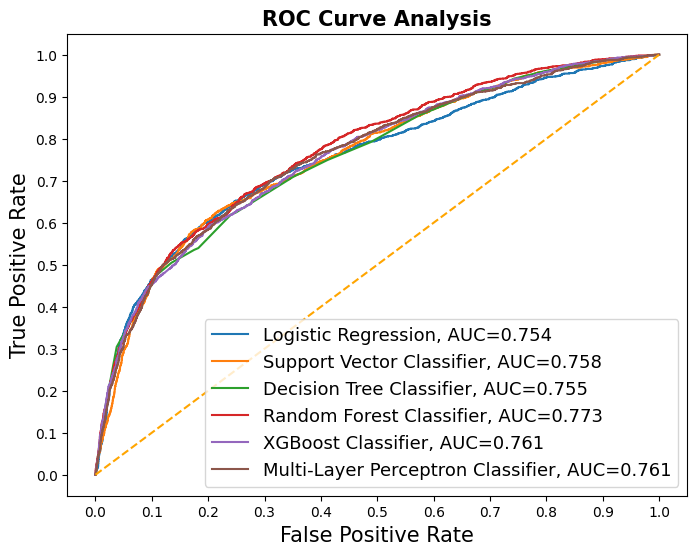

In [24]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()